<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/test_pinn_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 798.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.4 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.136769 s

'compile' took 1.185885 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.32e-01, 9.96e+03, 9.18e-09, 2.10e-03]    [2.94e-03, 9.96e+03, 9.18e-09, 2.10e-03]    []  
1000      [1.37e+01, 2.23e+03, 1.48e-12, 5.26e+00]    [2.40e-01, 2.23e+03, 1.48e-12, 5.26e+00]    []  
2000      [9.29e+00, 3.75e+02, 5.18e-09, 2.53e+00]    [1.21e+00, 3.75e+02, 5.18e-09, 2.53e+00]    []  
3000      [8.08e+00, 1.69e+01, 2.05e-11, 1.01e+00]    [9.58e-01, 1.69e+01, 2.05e-11, 1.01e+00]    []  
4000      [6.93e+00, 4.35e-01, 2.30e-09, 8.23e-01]    [8.57e-01, 4.35e-01, 

<ipython-input-2-3f14b5931a2d>:96: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  q_dynamic = (Q_flow / m_carbon) * trapz(C0 - breakthrough_curve, t)


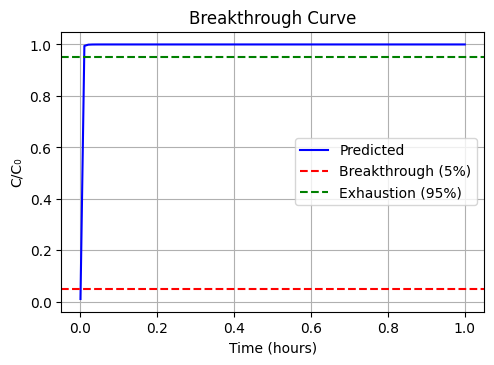

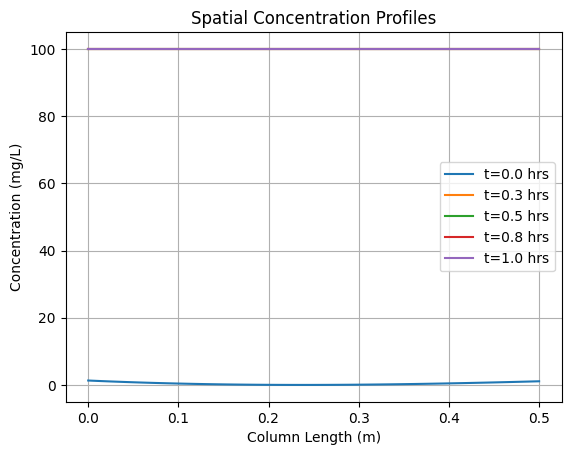

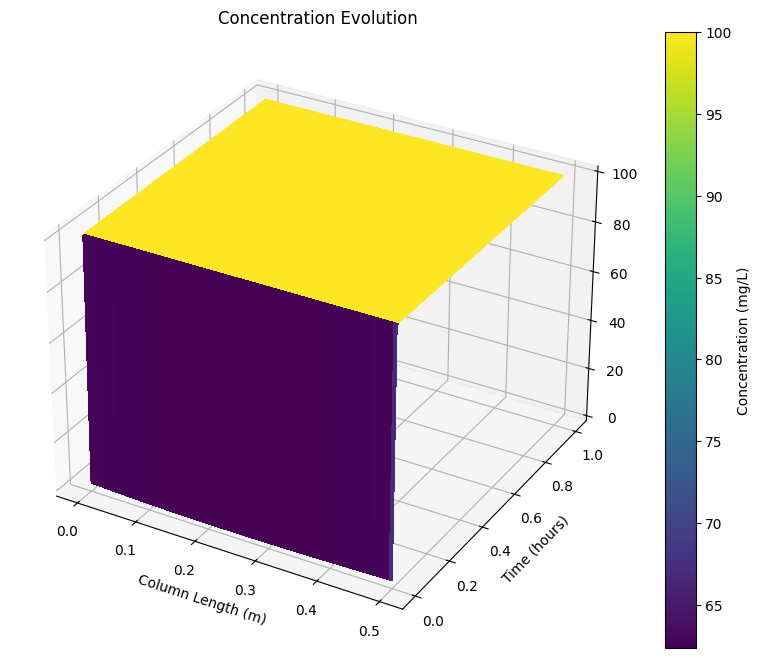


Performance Metrics:
Breakthrough time (t_b): 0.01 hours
Exhaustion time (t_e): 0.01 hours
Dynamic adsorption capacity: 283.21 mg/g
Utilization efficiency: 47201.1%


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.special import erfc


# Parameters for Hg²+ adsorption
D = 1       # Dispersion coefficient [m²/s]
v = 0.01       # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Max adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Define temporal-spatial domain (optionally include scaling/transformation)
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Modified PDE with proper porosity scaling
def pde(x, C):
    # Note: x[0]=x, x[1]=t
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)

    # Langmuir adsorption term (instantaneous equilibrium)
    dq_dC = q_max * K_L / (1 + K_L * C)**2
    dq_dt = dq_dC * dC_dt

    # Corrected PDE: note the division by theta for advection-dispersion terms
    return dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt

# Boundary conditions
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,  # Initial concentration = 0 (clean bed)
    lambda x, _: np.isclose(x[1], 0)
)
bc_inlet = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet)
# For advection-dominated flows, a zero gradient at outlet is common.
bc_outlet = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_inlet, bc_outlet, ic],
    num_domain=2000,
    num_boundary=200,
    num_initial=100,
    num_test=500
)

# Neural network architecture (considering further input scaling if needed)
net = dde.nn.FNN([2] + [50]*4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Training: first Adam then L-BFGS for better convergence
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=1000)
model.compile("L-BFGS")
model.train()

# Prediction grid (consider normalizing if necessary)
x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x, t)
grid = np.vstack((X.flatten(), T_grid.flatten())).T
C_pred = model.predict(grid).reshape(X.shape)

# Breakthrough curve at column outlet
outlet_idx = np.argmin(np.abs(x - L))
breakthrough_curve = C_pred[:, outlet_idx]

# Calculate performance metrics (ensure consistent units; here t in seconds is converted to hours)
C_normalized = breakthrough_curve / C0
t_array = t / 3600

# Find breakthrough and exhaustion times
t_b = t[np.argmax(C_normalized >= 0.05)] / 3600
t_e = t[np.argmax(C_normalized >= 0.95)] / 3600

# Calculate dynamic adsorption capacity (check units; here we integrate time in seconds)
Q_flow = v * np.pi * (0.1)**2 * 3600  # [m³/hr] for a 10cm radius column
m_carbon = rho_b * np.pi * (0.1)**2 * L  # [kg]
q_dynamic = (Q_flow / m_carbon) * trapz(C0 - breakthrough_curve, t)

# Visualization
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t_array, C_normalized, 'b-', label='Predicted')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curve')
plt.legend()
plt.grid(True)

num_time_points = C_pred.shape[0]
time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
plt.figure()
for ti in time_indices:
    plt.plot(x, C_pred[ti, :], label=f't={t[ti] / 3600:.1f} hrs')
plt.xlabel('Column Length (m)')
plt.ylabel('Concentration (mg/L)')
plt.title('Spatial Concentration Profiles')
plt.legend()
plt.grid(True)
plt.show()

# 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T_grid/3600, C_pred, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('Column Length (m)')
ax.set_ylabel('Time (hours)')
ax.set_title('Concentration Evolution')
fig.colorbar(surf, ax=ax, label='Concentration (mg/L)')
plt.show()

# Print performance metrics
print(f"\nPerformance Metrics:")
print(f"Breakthrough time (t_b): {t_b:.2f} hours")
print(f"Exhaustion time (t_e): {t_e:.2f} hours")
print(f"Dynamic adsorption capacity: {q_dynamic:.2f} mg/g")
print(f"Utilization efficiency: {(q_dynamic/q_max)*100:.1f}%")

Compiling model...
Building feed-forward neural network...
'build' took 0.104931 s

'compile' took 1.405206 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.06e+03, 5.05e-03, 9.99e+03, 5.09e-04, 1.82e-04, 3.23e-04]    [4.97e+03, 4.95e-03, 9.99e+03, 5.09e-04, 1.82e-04, 3.23e-04]    []  
1000      [1.10e+01, 1.94e-03, 2.35e+03, 4.64e-01, 1.17e+03, 2.45e-06]    [8.16e+00, 1.37e-03, 2.35e+03, 4.64e-01, 1.17e+03, 2.45e-06]    []  
2000      [1.50e+02, 5.27e-02, 4.46e+02, 1.59e+01, 1.89e+01, 2.61e-05]    [6.89e+01, 3.23e-02, 4.46e+02, 1.59e+01, 1.89e+01, 2.61e-05]    []  
3000      [5.92e-01, 8.38e-02, 2.79e+02, 4.76e+00, 1.90e+01, 6.12e-06]    [4.57e-01, 4.76e-02, 2.79e+02, 4.76e+00, 1.90e+01, 6.12e-06]    []  
4000      [4.04e-01, 9.09e-02, 2.58e+02, 3.99e+00, 1.84e+01, 7.38e-06]    [3.20e-01, 5.13e-02, 2.58e+02, 3.99e+00, 1.84e+01, 7.38e-06]    []  
5000 

<ipython-input-6-003295aaf190>:133: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  q_dynamic = (Q_flow_L_hr / m_carbon_g) * trapz(C0 - breakthrough_curve, t_array) # Integrate with time in hours


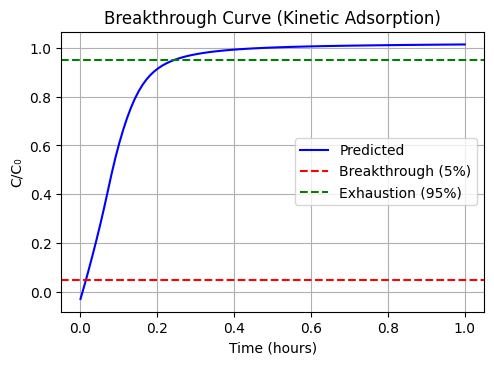

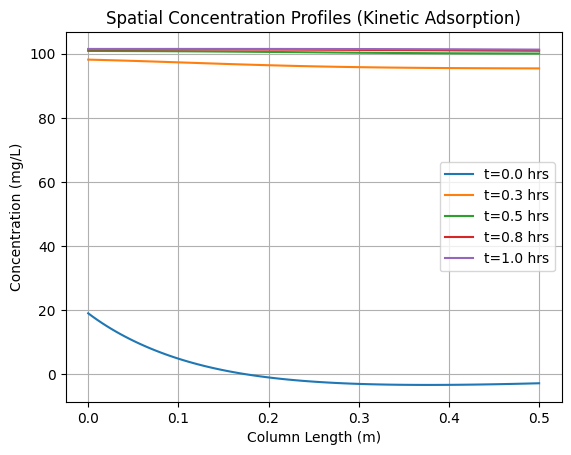

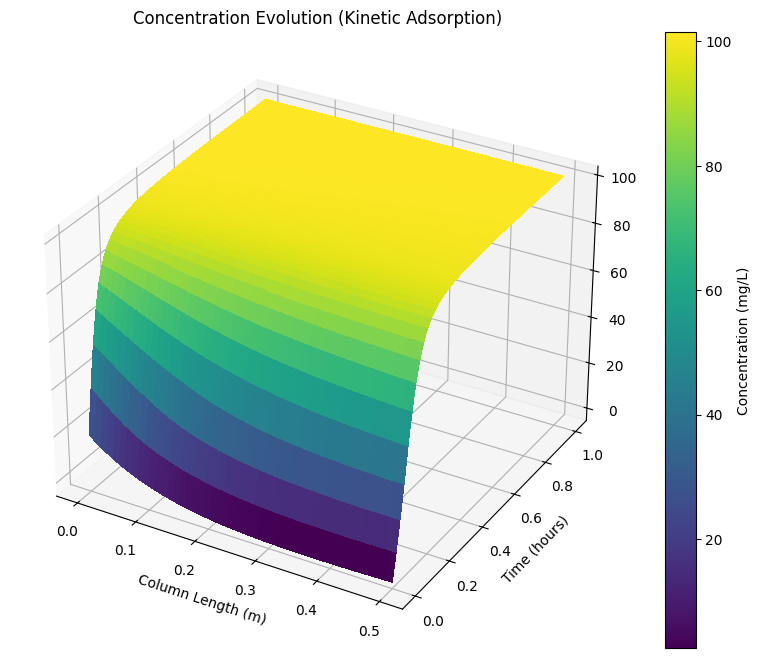


Performance Metrics (Kinetic Adsorption):
Breakthrough time (t_b): 0.02 hours
Exhaustion time (t_e): 0.25 hours
Dynamic adsorption capacity: 1.52 mg/g
Utilization efficiency: 254.1%


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parameters for Hg²+ adsorption
D = 5e-5       # Dispersion coefficient [m²/s]
v = 0.01       # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Max adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Kinetic parameters (First-Order Reversible)
k_f = 2e-4      # Forward rate constant [L/(mg*s)] - Example value, adjust if needed
k_r = k_f / K_L # Reverse rate constant [1/s]

# Define temporal-spatial domain with SCALED time
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)  # Scaled time domain 0 to 1
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Modified PDE function for kinetic adsorption (now returns TWO residuals)
def pde(x, y):
    C = y[:, 0:1]  # Aqueous concentration (first output of NN)
    q = y[:, 1:2]  # Adsorbed concentration (second output of NN)

    dC_dt = dde.grad.jacobian(C, x, i=0, j=1) # Derivative wrt SCALED time input
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    dq_dt = dde.grad.jacobian(q, x, i=0, j=1) # Derivative of q wrt SCALED time

    # Kinetic adsorption term (First-Order Reversible)
    adsorption_rate = k_f * C * (q_max - q) - k_r * q

    # PDE for aqueous concentration C
    pde_C = dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt

    # PDE for adsorbed concentration q (kinetic equation)
    pde_q = dq_dt - adsorption_rate

    return [pde_C, pde_q] # Return a list of two residuals


# Boundary conditions (for C only, same as before)
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# Initial conditions (for C and q)
ic_C = dde.icbc.IC(
    geomtime,
    lambda x: 0,  # Initial aqueous concentration = 0 (clean bed)
    lambda x, _: np.isclose(x[1], 0), # t=0 in SCALED time
    component=0 # Apply IC to the first component (C)
)
ic_q = dde.icbc.IC(
    geomtime,
    lambda x: 0,  # Initial adsorbed concentration = 0 (clean bed)
    lambda x, _: np.isclose(x[1], 0), # t=0 in SCALED time
    component=1 # Apply IC to the second component (q)
)


bc_inlet_C = dde.icbc.DirichletBC(
    geomtime,
    lambda x: C0,
    boundary_inlet,
    component=0 # Apply BC to the first component (C)
)
bc_outlet_C = dde.icbc.NeumannBC(
    geomtime,
    lambda x: 0,
    boundary_outlet,
    component=0 # Apply BC to the first component (C)
)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_inlet_C, bc_outlet_C, ic_C, ic_q], # List of BCs and ICs
    num_domain=2000,
    num_boundary=200,
    num_initial=100,
    num_test=500
)

# Neural network architecture (now predicts TWO outputs: C and q)
net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal") # Output size is now 2
model = dde.Model(data, net)

# Training: first Adam then L-BFGS for better convergence
model.compile("adam", lr=1e-3) # Removed loss_weights
model.train(iterations=10000, display_every=1000)
model.compile("L-BFGS")
model.train()

# Prediction grid (using SCALED time for input, converting to real time for plotting)
x = np.linspace(0, L, 100)
t_scaled = np.linspace(0, 1, 100) # Scaled time for prediction input
t = t_scaled * T # Real time for plotting
X, T_scaled_grid = np.meshgrid(x, t_scaled) # Scaled time grid for NN input
grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
y_pred = model.predict(grid) # Predict BOTH C and q
C_pred = y_pred[:, 0:1].reshape(X.shape) # Extract C prediction
q_pred = y_pred[:, 1:2].reshape(X.shape) # Extract q prediction


# Breakthrough curve at column outlet (plotting against REAL time)
outlet_idx = np.argmin(np.abs(x - L))
breakthrough_curve = C_pred[:, outlet_idx]

# Calculate performance metrics (using REAL time for metrics) - Still based on C only
C_normalized = breakthrough_curve / C0
t_array = t / 3600 # Real time in hours

# Find breakthrough and exhaustion times (using REAL time)
t_b = t[np.argmax(C_normalized >= 0.05)] / 3600
t_e = t[np.argmax(C_normalized >= 0.95)] / 3600

# Calculate dynamic adsorption capacity (using REAL time and corrected formula) - Still based on C
column_area = np.pi * (0.1)**2 # [m^2]
Q_flow_m3_s = v * column_area # [m^3/s]
Q_flow_L_hr = Q_flow_m3_s * (1000 * 3600) # [L/hr]
m_carbon_kg = rho_b * column_area * L # [kg]
m_carbon_g = m_carbon_kg * 1000 # [g]
q_dynamic = (Q_flow_L_hr / m_carbon_g) * trapz(C0 - breakthrough_curve, t_array) # Integrate with time in hours

# Visualization (plotting against REAL time) - Plots for C only
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t_array, C_normalized, 'b-', label='Predicted')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curve (Kinetic Adsorption)') # Title updated
plt.legend()
plt.grid(True)

num_time_points = C_pred.shape[0]
time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
plt.figure()
for ti in time_indices:
    plt.plot(x, C_pred[ti, :], label=f't={t[ti] / 3600:.1f} hrs') # REAL time on label
plt.xlabel('Column Length (m)')
plt.ylabel('Concentration (mg/L)')
plt.title('Spatial Concentration Profiles (Kinetic Adsorption)') # Title updated
plt.legend()
plt.grid(True)
plt.show()

# 3D surface plot (plotting against REAL time)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T_grid/3600, C_pred, cmap='viridis', linewidth=0, antialiased=False) # T_grid/3600 for REAL time axis label
ax.set_xlabel('Column Length (m)')
ax.set_ylabel('Time (hours)') # REAL time axis label
ax.set_title('Concentration Evolution (Kinetic Adsorption)') # Title updated
fig.colorbar(surf, ax=ax, label='Concentration (mg/L)')
plt.show()

# Print performance metrics
print(f"\nPerformance Metrics (Kinetic Adsorption):") # Updated print statement
print(f"Breakthrough time (t_b): {t_b:.2f} hours")
print(f"Exhaustion time (t_e): {t_e:.2f} hours")
print(f"Dynamic adsorption capacity: {q_dynamic:.2f} mg/g")
print(f"Utilization efficiency: {(q_dynamic/q_max)*100:.1f}%")


--- Simulating for Region: Guadalupe (D = 8.41e-10) ---
Compiling model...
Building feed-forward neural network...
'build' took 0.114141 s

'compile' took 1.188001 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.06e+03, 5.05e-03, 9.99e+03, 4.23e-04, 1.82e-04, 3.23e-04]    [4.97e+03, 4.95e-03, 9.99e+03, 4.23e-04, 1.82e-04, 3.23e-04]    []  
1000      [5.51e+00, 2.07e-03, 2.86e+03, 1.39e+02, 6.59e+02, 9.70e-05]    [3.34e+00, 1.62e-03, 2.86e+03, 1.39e+02, 6.59e+02, 9.70e-05]    []  
2000      [1.93e+00, 6.04e-02, 5.31e+02, 1.51e+01, 6.62e+01, 2.13e-05]    [1.07e+00, 3.33e-02, 5.31e+02, 1.51e+01, 6.62e+01, 2.13e-05]    []  
3000      [6.36e+02, 1.13e-01, 3.48e+02, 4.60e+01, 1.87e+01, 1.25e-04]    [1.75e+02, 5.98e-02, 3.48e+02, 4.60e+01, 1.87e+01, 1.25e-04]    []  
4000      [1.38e+00, 1.25e-01, 2.58e+02, 4.30e+00, 3.18e+01, 2.23e-05]    [1.06e+00, 6.08e-

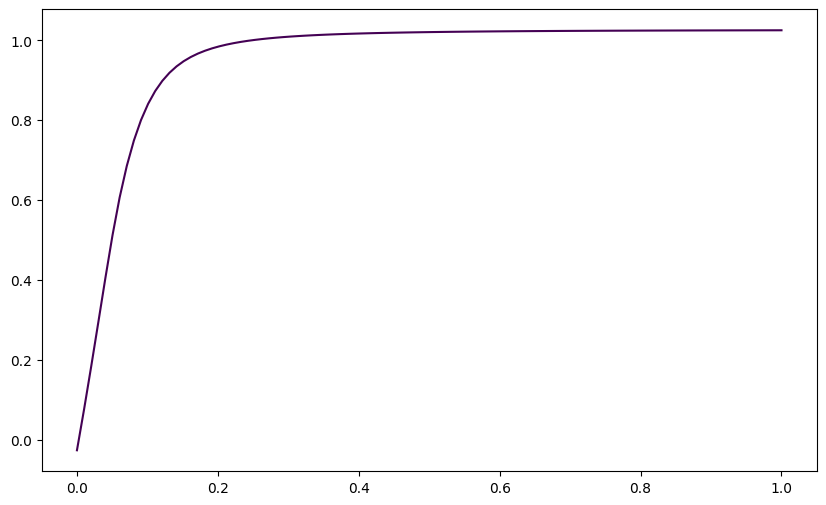

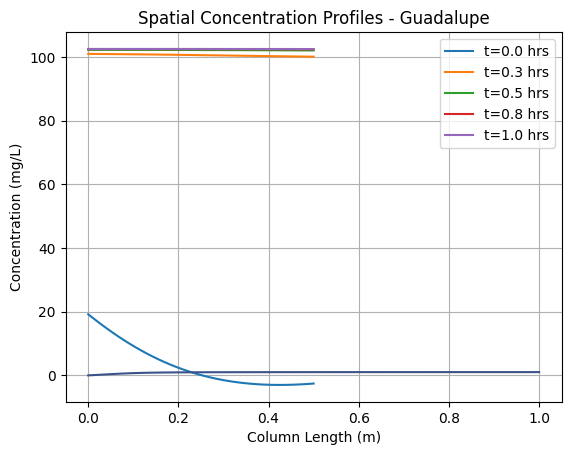

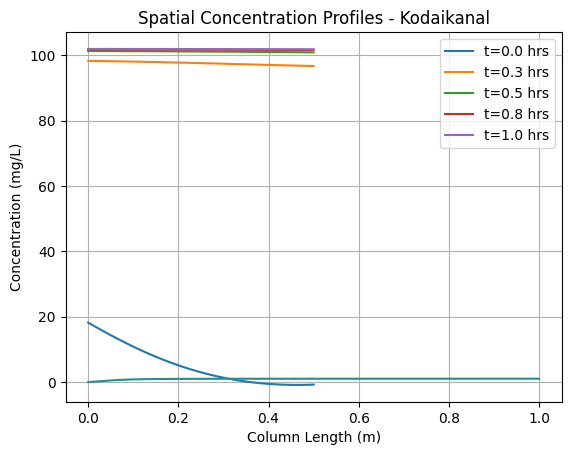

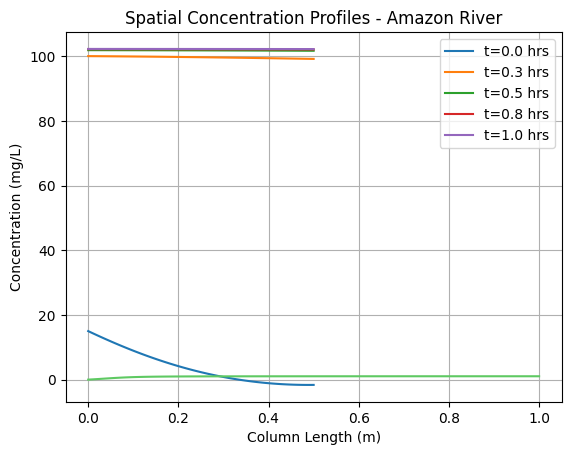

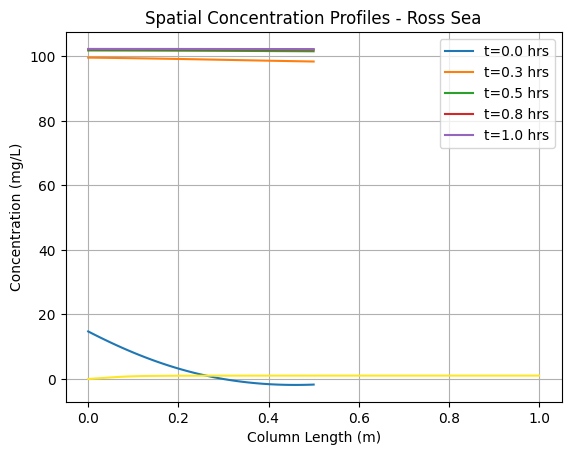

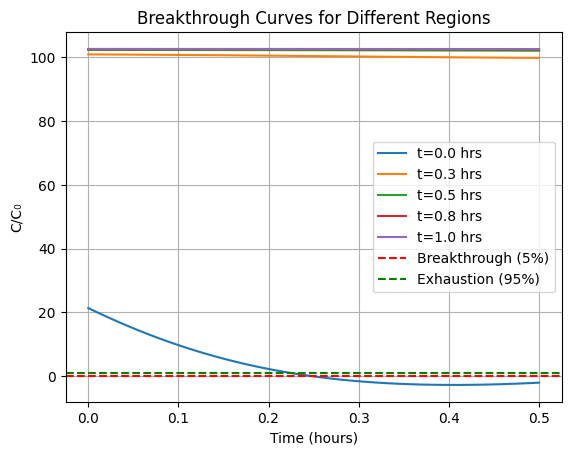


--- Simulations and Plots Completed ---


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parameters for Hg²+ adsorption (base values - will keep v, rho_b, etc. constant)
v = 0.01       # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Max adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Kinetic parameters (First-Order Reversible - base values)
k_f = 2e-4      # Forward rate constant [L/(mg*s)]
k_r = k_f / K_L # Reverse rate constant [1/s]

# Diffusivity values for different regions (from your table)
region_diffusivities = {
    "Guadalupe": 8.41e-10,
    "Kodaikanal": 7.45e-10,
    "Amazon River": 9.91e-10,
    "Ross Sea": 1.23e-10,
    "Lake Superior": 4.53e-10,
}

# Time domain scaling
T_scaled_max = 1.0

# --- Main loop to run simulations for each region ---
plt.figure(figsize=(10, 6)) # For integrated breakthrough curve plot
spatial_profiles_figures = {} # Dictionary to store spatial profile figures per region

region_names = list(region_diffusivities.keys()) # Get region names for ordered plotting
colors = plt.cm.viridis(np.linspace(0, 1, len(region_names))) # Color map for regions

for i, region_name in enumerate(region_names):
    D = region_diffusivities[region_name] # Set D for the current region
    print(f"\n--- Simulating for Region: {region_name} (D = {D:.2e}) ---")

    # Define temporal-spatial domain with SCALED time
    geom = dde.geometry.Interval(0, L)
    timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Modified PDE function for kinetic adsorption (same as before)
    def pde(x, y):
        C = y[:, 0:1]
        q = y[:, 1:2]
        dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
        dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
        d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
        dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
        adsorption_rate = k_f * C * (q_max - q) - k_r * q
        pde_C = dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt
        pde_q = dq_dt - adsorption_rate
        return [pde_C, pde_q]

    # Boundary and Initial Conditions (same as before)
    def boundary_inlet(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0)
    def boundary_outlet(x, on_boundary):
        return on_boundary and np.isclose(x[0], L)
    ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
    ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
    bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
    bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
        num_domain=2000,
        num_boundary=200,
        num_initial=100,
        num_test=500
    )

    net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    model.compile("adam", lr=1e-3)
    model.train(iterations=5000, display_every=1000) # Reduced iterations for multiple runs
    model.compile("L-BFGS")
    model.train()

    # Prediction (same as before, using scaled time)
    x = np.linspace(0, L, 100)
    t_scaled = np.linspace(0, T_scaled_max, 100)
    t = t_scaled * T
    X, T_scaled_grid = np.meshgrid(x, t_scaled)
    grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
    y_pred = model.predict(grid)
    C_pred = y_pred[:, 0:1].reshape(X.shape)
    q_pred = y_pred[:, 1:2].reshape(X.shape)

    # Breakthrough curve calculation
    outlet_idx = np.argmin(np.abs(x - L))
    breakthrough_curve = C_pred[:, outlet_idx]
    C_normalized = breakthrough_curve / C0
    t_array = t / 3600 # Time in hours

    # Plotting Breakthrough Curve (integrated plot)
    plt.plot(t_array, C_normalized, label=region_name, color=colors[i])

    # --- Spatial Concentration Profiles (Separate plots per region) ---
    spatial_fig = plt.figure()
    spatial_profiles_figures[region_name] = spatial_fig # Store figure in dictionary
    ax_spatial = spatial_fig.add_subplot(1, 1, 1)
    num_time_points = C_pred.shape[0]
    time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
    for ti in time_indices:
        ax_spatial.plot(x, C_pred[ti, :], label=f't={t[ti] / 3600:.1f} hrs')
    ax_spatial.set_xlabel('Column Length (m)')
    ax_spatial.set_ylabel('Concentration (mg/L)')
    ax_spatial.set_title(f'Spatial Concentration Profiles - {region_name}')
    ax_spatial.legend()
    ax_spatial.grid(True)


# --- Finalize Integrated Breakthrough Curve Plot ---
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curves for Different Regions')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.legend()
plt.grid(True)
plt.show()


# --- Show Spatial Profile Figures (separate for each region) ---
for region_name, fig in spatial_profiles_figures.items():
    fig.show()

print("\n--- Simulations and Plots Completed ---")


--- Simulating for Region: Guadalupe (D = 8.41e-10) ---
Compiling model...
Building feed-forward neural network...
'build' took 0.071537 s

'compile' took 1.225654 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.26e+04, 6.25e-02, 1.00e+04, 1.76e-04, 4.49e-05, 1.80e-02]    [6.11e+04, 6.10e-02, 1.00e+04, 1.75e-04, 4.51e-05, 1.80e-02]    []  
1000      [1.51e+01, 3.37e-04, 2.86e+03, 8.10e+01, 1.45e+03, 9.57e-04]    [9.85e+00, 2.78e-04, 2.86e+03, 8.10e+01, 1.45e+03, 9.57e-04]    []  
2000      [2.97e+00, 2.99e-02, 6.16e+02, 1.69e+01, 9.84e+01, 2.61e-05]    [2.04e+00, 2.41e-02, 6.16e+02, 1.70e+01, 9.84e+01, 2.64e-05]    []  
3000      [2.17e+00, 5.37e-02, 4.10e+02, 1.15e+01, 4.91e+01, 1.69e-05]    [1.85e+00, 3.97e-02, 4.10e+02, 1.15e+01, 4.91e+01, 1.66e-05]    []  
4000      [1.68e+00, 6.04e-02, 3.80e+02, 1.03e+01, 4.52e+01, 1.35e-05]    [1.48e+00, 4.33e-

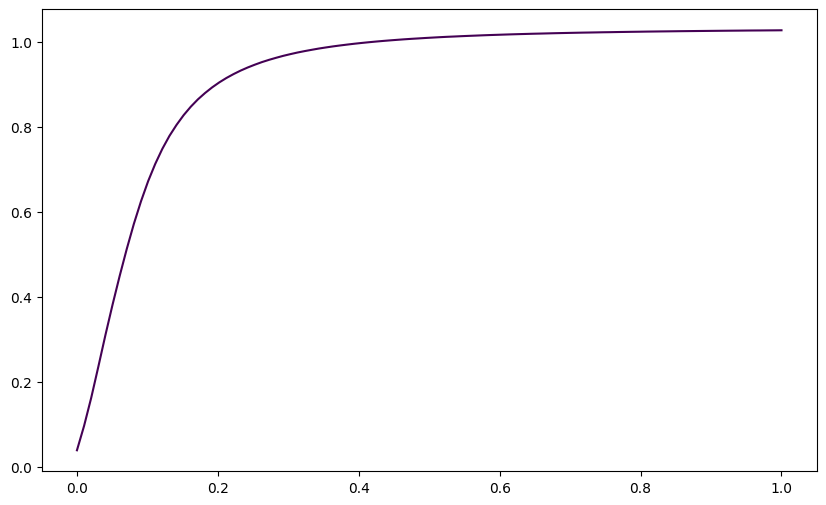

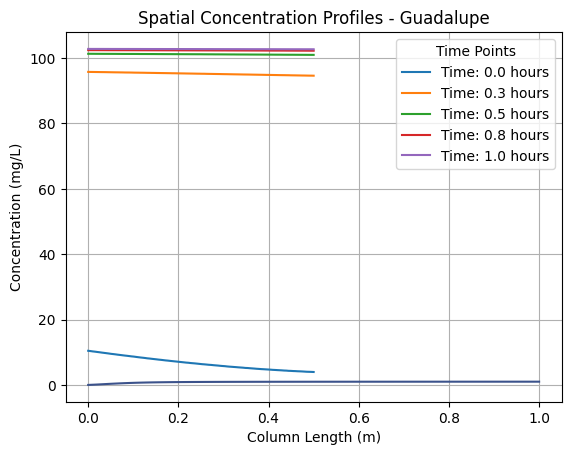

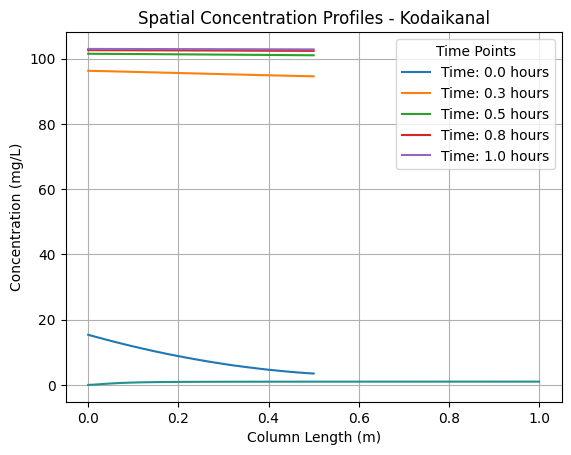

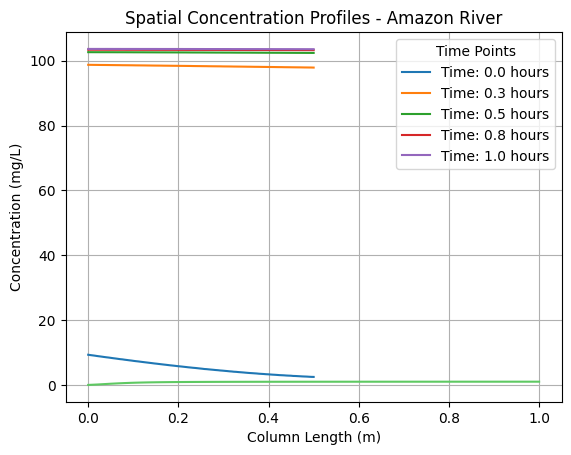

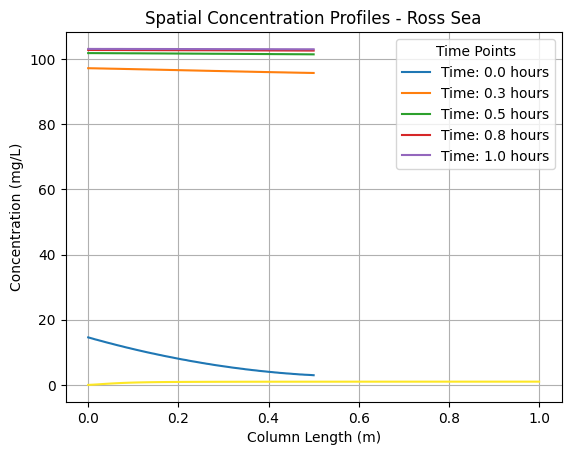

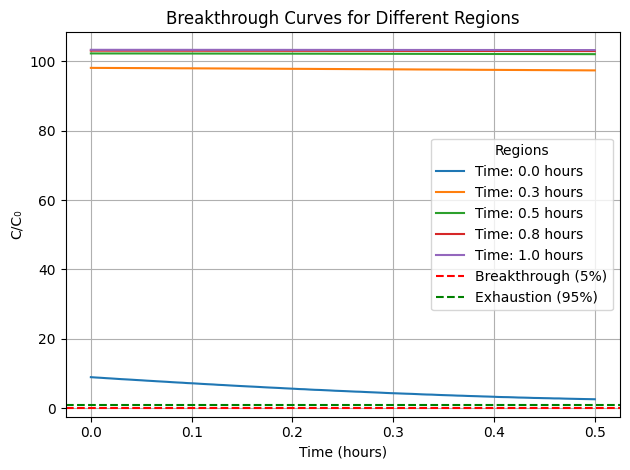


--- Simulations and Plots Completed ---


<ipython-input-10-b33b931c218b>:182: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])


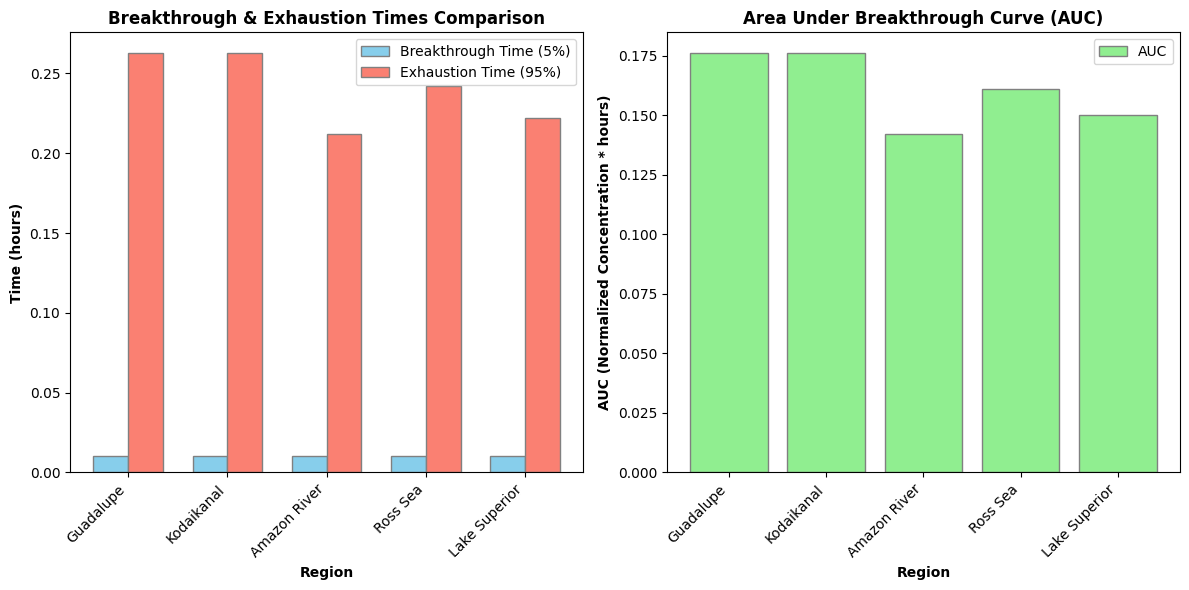


--- Contrastive Visualizations Completed ---


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parameters for Hg²+ adsorption (base values - will keep v, rho_b, etc. constant)
v = 0.01       # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Max adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Kinetic parameters (First-Order Reversible - base values)
k_f = 2e-4      # Forward rate constant [L/(mg*s)]
k_r = k_f / K_L # Reverse rate constant [1/s]

# Diffusivity values for different regions (from your table)
region_diffusivities = {
    "Guadalupe": 8.41e-10,
    "Kodaikanal": 7.45e-10,
    "Amazon River": 9.91e-10,
    "Ross Sea": 1.23e-10,
    "Lake Superior": 4.53e-10,
}

# Time domain scaling
T_scaled_max = 1.0

# --- Main loop to run simulations for each region ---
plt.figure(figsize=(10, 6)) # For integrated breakthrough curve plot
spatial_profiles_figures = {} # Dictionary to store spatial profile figures per region
breakthrough_data = {} # Dictionary to store breakthrough data for contrast plots

region_names = list(region_diffusivities.keys()) # Get region names for ordered plotting
colors = plt.cm.viridis(np.linspace(0, 1, len(region_names))) # Color map for regions

for i, region_name in enumerate(region_names):
    D = region_diffusivities[region_name] # Set D for the current region
    print(f"\n--- Simulating for Region: {region_name} (D = {D:.2e}) ---")

    # Define temporal-spatial domain with SCALED time
    geom = dde.geometry.Interval(0, L)
    timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Modified PDE function for kinetic adsorption (same as before)
    def pde(x, y):
        C = y[:, 0:1]
        q = y[:, 1:2]
        dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
        dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
        d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
        dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
        adsorption_rate = k_f * C * (q_max - q) - k_r * q
        pde_C = dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt
        pde_q = dq_dt - adsorption_rate
        return [pde_C, pde_q]

    # Boundary and Initial Conditions (same as before)
    def boundary_inlet(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0)
    def boundary_outlet(x, on_boundary):
        return on_boundary and np.isclose(x[0], L)
    ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
    ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
    bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
    bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
        num_domain=2000,
        num_boundary=200,
        num_initial=100,
        num_test=500
    )

    net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    model.compile("adam", lr=1e-3)
    model.train(iterations=5000, display_every=1000) # Reduced iterations for multiple runs
    model.compile("L-BFGS")
    model.train()

    # Prediction (same as before, using scaled time)
    x = np.linspace(0, L, 100)
    t_scaled = np.linspace(0, T_scaled_max, 100)
    t = t_scaled * T
    X, T_scaled_grid = np.meshgrid(x, t_scaled)
    grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
    y_pred = model.predict(grid)
    C_pred = y_pred[:, 0:1].reshape(X.shape)
    q_pred = y_pred[:, 1:2].reshape(X.shape)

    # Breakthrough curve calculation
    outlet_idx = np.argmin(np.abs(x - L))
    breakthrough_curve = C_pred[:, outlet_idx]
    C_normalized = breakthrough_curve / C0
    t_array = t / 3600 # Time in hours

    # Store breakthrough data
    breakthrough_data[region_name] = {
        'C_normalized': C_normalized,
        't_array': t_array
    }

    # Plotting Breakthrough Curve (integrated plot)
    plt.plot(t_array, C_normalized, label=region_name, color=colors[i])

    # --- Spatial Concentration Profiles (Separate plots per region) ---
    spatial_fig = plt.figure()
    spatial_profiles_figures[region_name] = spatial_fig # Store figure in dictionary
    ax_spatial = spatial_fig.add_subplot(1, 1, 1)
    num_time_points = C_pred.shape[0]
    time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
    time_labels_spatial = [f'{t[ti] / 3600:.1f} hours' for ti in time_indices] # Create time labels for legend
    for idx, ti in enumerate(time_indices):
        ax_spatial.plot(x, C_pred[ti, :], label=f'Time: {time_labels_spatial[idx]}') # More descriptive legend
    ax_spatial.set_xlabel('Column Length (m)')
    ax_spatial.set_ylabel('Concentration (mg/L)')
    ax_spatial.set_title(f'Spatial Concentration Profiles - {region_name}')
    ax_spatial.legend(title='Time Points') # Added legend title
    ax_spatial.grid(True)


# --- Finalize Integrated Breakthrough Curve Plot ---
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curves for Different Regions')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.legend(title='Regions') # Added legend title
plt.grid(True)
plt.tight_layout() # Added for better layout
plt.show()


# --- Show Spatial Profile Figures (separate for each region) ---
for region_name, fig in spatial_profiles_figures.items():
    fig.tight_layout() # Added for better layout in spatial plots
    fig.show()

print("\n--- Simulations and Plots Completed ---")

# --- Additional Contrastive Visualizations ---
plt.figure(figsize=(12, 6)) # For contrastive plots

# 1. Breakthrough Time and Exhaustion Time Calculation & Bar Plot
breakthrough_times = {}
exhaustion_times = {}
auc_values = {}

for region_name, data in breakthrough_data.items():
    C_normalized = data['C_normalized']
    t_array = data['t_array']

    #Find Breakthrough Time (5%)
    breakthrough_index = np.where(C_normalized >= 0.05)[0]
    if len(breakthrough_index) > 0:
        breakthrough_times[region_name] = t_array[breakthrough_index[0]]
    else:
        breakthrough_times[region_name] = np.nan #Not reached in sim time

    #Find Exhaustion Time (95%)
    exhaustion_index = np.where(C_normalized >= 0.95)[0]
    if len(exhaustion_index) > 0:
        exhaustion_times[region_name] = t_array[exhaustion_index[0]]
    else:
        exhaustion_times[region_name] = np.nan #Not reached in sim time

    # Calculate AUC up to exhaustion (or end of sim if no exhaustion)
    valid_indices_auc = np.where(~np.isnan(C_normalized))[0] # Avoid NaN in integration
    if not np.isnan(exhaustion_times[region_name]):
        exhaustion_time_auc = exhaustion_times[region_name]
        exhaustion_index_auc = np.where(t_array <= exhaustion_time_auc)[0][-1] if len(np.where(t_array <= exhaustion_time_auc)[0]) > 0 else -1
        if exhaustion_index_auc > 0:
            auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])
        else:
             auc_values[region_name] = 0 #No exhaustion point within sim
    else: #If no exhaustion, calculate AUC over full simulation time.
        auc_values[region_name] = trapz(C_normalized[valid_indices_auc], t_array[valid_indices_auc]) if len(valid_indices_auc) > 1 else 0


# Bar plots for Breakthrough Time and Exhaustion Time
bar_width = 0.35
r1 = np.arange(len(region_names))
r2 = [x + bar_width for x in r1]

plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
plt.bar(r1, [breakthrough_times.get(region, 0) for region in region_names], color='skyblue', width=bar_width, edgecolor='grey', label='Breakthrough Time (5%)')
plt.bar(r2, [exhaustion_times.get(region, 0) for region in region_names], color='salmon', width=bar_width, edgecolor='grey', label='Exhaustion Time (95%)')
plt.xlabel('Region', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in r1], region_names, rotation=45, ha='right') # Rotate labels
plt.ylabel('Time (hours)', fontweight='bold')
plt.title('Breakthrough & Exhaustion Times Comparison', fontweight='bold')
plt.legend()


# Bar plot for AUC
plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
plt.bar(region_names, [auc_values.get(region, 0) for region in region_names], color='lightgreen', edgecolor='grey', label='AUC')
plt.xlabel('Region', fontweight='bold')
plt.xticks(rotation=45, ha='right') # Rotate labels
plt.ylabel('AUC (Normalized Concentration * hours)', fontweight='bold')
plt.title('Area Under Breakthrough Curve (AUC)', fontweight='bold')
plt.legend()

plt.tight_layout() # Adjust layout for better spacing
plt.show()

print("\n--- Contrastive Visualizations Completed ---")

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import seaborn as sns
import pandas as pd
import pickle # For saving and loading data

# --- Parameters (Keep these at the top for easy modification) ---
# Adsorption Parameters
v = 0.01
rho_b = 450
theta = 0.45
q_max = 0.6
K_L = 0.15
L = 0.5
T = 36000
C0 = 100

# Kinetic Parameters
k_f = 2e-4
k_r = k_f / K_L

# Diffusivity Values
region_diffusivities = {
    "Guadalupe": 8.41e-10,
    "Kodaikanal": 7.45e-10,
    "Amazon River": 9.91e-10,
    "Ross Sea": 1.23e-10,
    "Lake Superior": 4.53e-10,
}

T_scaled_max = 1.0
region_names = list(region_diffusivities.keys())


# --- Training Phase Code Block ---
def training_phase(retrain=False, save_data=True, data_filename="pinn_data.pkl"):
    """
    Executes the PINN training for each region and saves the results.

    Args:
        retrain (bool): If True, retrains the model for all regions. If False, loads saved data if available.
        save_data (bool): If True, saves the generated data to a pickle file.
        data_filename (str): Filename for saving/loading data.

    Returns:
        tuple: breakthrough_data, spatial_data dictionaries.
               Returns None, None if loading fails and retrain is False.
    """

    if not retrain:
        try:
            with open(data_filename, 'rb') as f:
                loaded_data = pickle.load(f)
                print(f"--- Loaded data from {data_filename} ---")
                return loaded_data['breakthrough_data'], loaded_data['spatial_data']
        except FileNotFoundError:
            print("--- No saved data found. Proceeding with training. ---")
        except Exception as e:
            print(f"--- Error loading data: {e}. Proceeding with training. ---")


    breakthrough_data = {}
    spatial_data = {}

    for region_name in region_names:
        D = region_diffusivities[region_name]
        print(f"\n--- Training for Region: {region_name} (D = {D:.2e}) ---")

        # Domain, PDE, BCs, ICs, Data - [No changes here from previous code]
        geom = dde.geometry.Interval(0, L)
        timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
        geomtime = dde.geometry.GeometryXTime(geom, timedomain)

        def pde(x, y):
            C = y[:, 0:1]
            q = y[:, 1:2]
            dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
            dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
            d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
            dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
            adsorption_rate = k_f * C * (q_max - q) - k_r * q
            pde_C = dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt
            pde_q = dq_dt - adsorption_rate
            return [pde_C, pde_q]

        def boundary_inlet(x, on_boundary):
            return on_boundary and np.isclose(x[0], 0)
        def boundary_outlet(x, on_boundary):
            return on_boundary and np.isclose(x[0], L)
        ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
        ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
        bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
        bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

        data = dde.data.TimePDE(
            geomtime,
            pde,
            [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
            num_domain=2000,
            num_boundary=200,
            num_initial=100,
            num_test=500
        )

        net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
        model = dde.Model(data, net)

        model.compile("adam", lr=1e-3)
        model.train(iterations=5000, display_every=1000)
        model.compile("L-BFGS")
        model.train()

        # Prediction - [No changes here from previous code]
        x = np.linspace(0, L, 100)
        t_scaled = np.linspace(0, T_scaled_max, 100)
        t = t_scaled * T
        X, T_scaled_grid = np.meshgrid(x, t_scaled)
        grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
        y_pred = model.predict(grid)
        C_pred = y_pred[:, 0:1].reshape(X.shape)
        q_pred = y_pred[:, 1:2].reshape(X.shape)

        # Breakthrough curve calculation - [No changes here from previous code]
        outlet_idx = np.argmin(np.abs(x - L))
        breakthrough_curve = C_pred[:, outlet_idx]
        C_normalized = breakthrough_curve / C0
        t_array = t / 3600

        breakthrough_data[region_name] = {
            'C_normalized': C_normalized,
            't_array': t_array
        }
        spatial_data[region_name] = {
            'C_spatial': C_pred,
            'q_spatial': q_pred,
            'x': x,
            't': t
        }

    if save_data:
        data_to_save = {'breakthrough_data': breakthrough_data, 'spatial_data': spatial_data}
        with open(data_filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"--- Data saved to {data_filename} ---")

    return breakthrough_data, spatial_data



# --- Run Training Phase (Set retrain=True to force retraining, otherwise it loads saved data) ---
breakthrough_data_results, spatial_data_results = training_phase(retrain=True) # Set retrain=True to re-run training




--- Training for Region: Guadalupe (D = 8.41e-10) ---
Compiling model...
Building feed-forward neural network...
'build' took 0.071313 s

'compile' took 2.037624 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.26e+04, 6.25e-02, 1.00e+04, 1.73e-04, 4.49e-05, 1.80e-02]    [6.11e+04, 6.10e-02, 1.00e+04, 1.71e-04, 4.51e-05, 1.80e-02]    []  
1000      [1.37e+01, 3.00e-04, 2.85e+03, 8.16e+01, 1.49e+03, 9.04e-04]    [9.14e+00, 2.52e-04, 2.85e+03, 8.16e+01, 1.49e+03, 9.08e-04]    []  
2000      [1.49e+01, 3.03e-02, 5.01e+02, 7.59e+00, 3.00e+02, 2.41e-05]    [1.31e+01, 2.21e-02, 5.01e+02, 7.57e+00, 3.00e+02, 2.40e-05]    []  
3000      [8.39e+02, 6.72e-02, 3.45e+02, 2.84e+01, 9.33e+01, 9.53e-05]    [5.03e+02, 4.82e-02, 3.45e+02, 2.85e+01, 9.33e+01, 9.47e-05]    []  
4000      [3.67e+01, 6.98e-02, 3.12e+02, 9.66e+00, 3.72e+01, 1.25e-05]    [1.74e+01, 4.79e-02

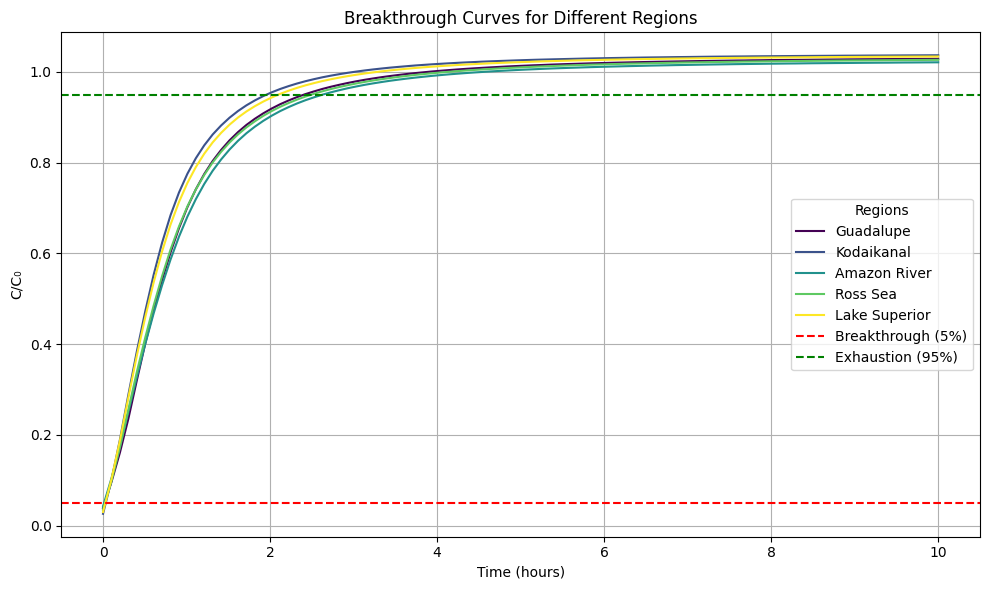

<ipython-input-16-8f88250aedfb>:85: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])


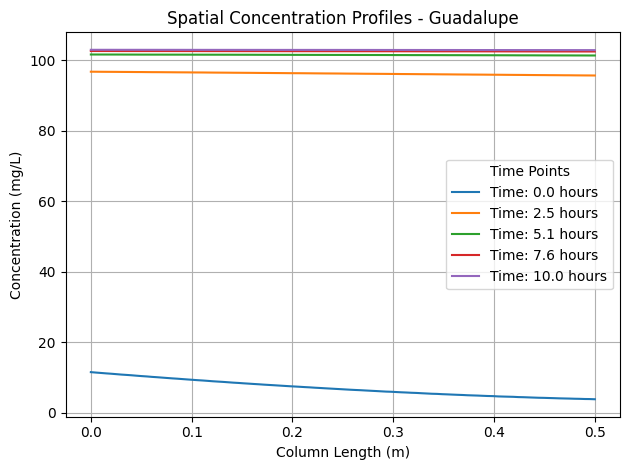

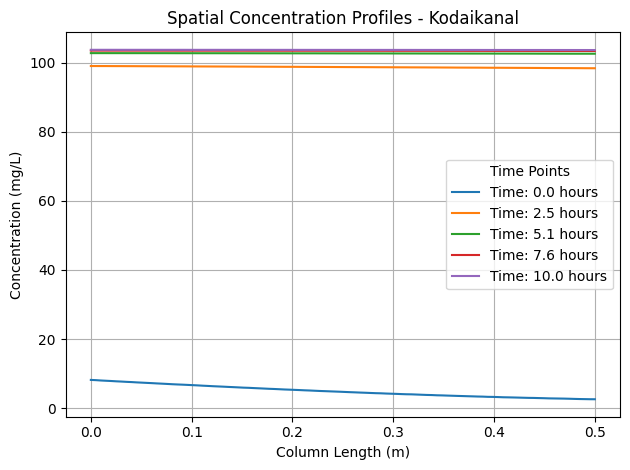

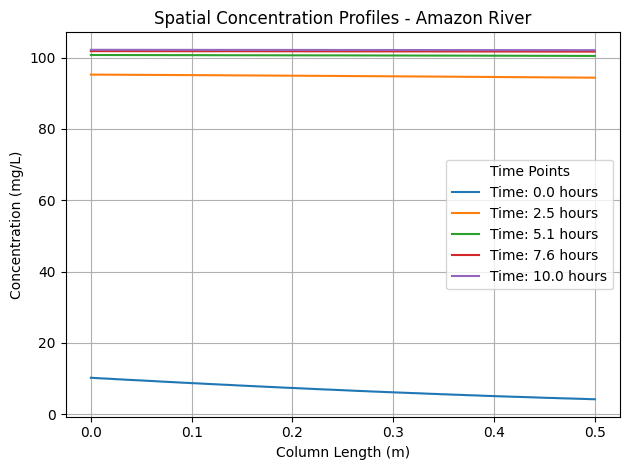

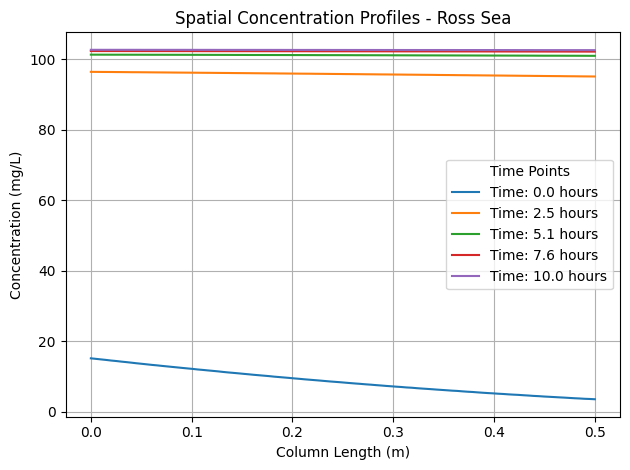

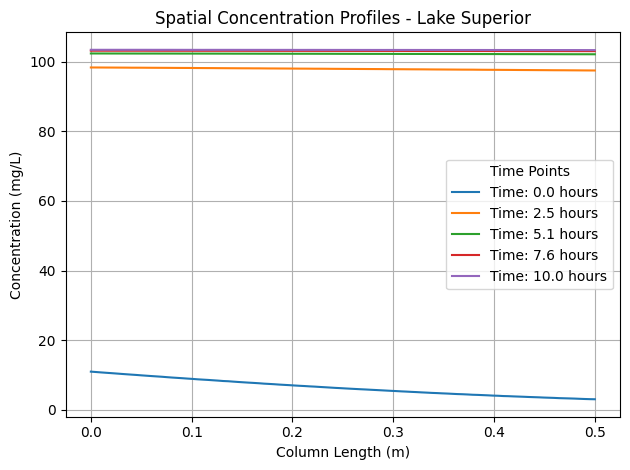

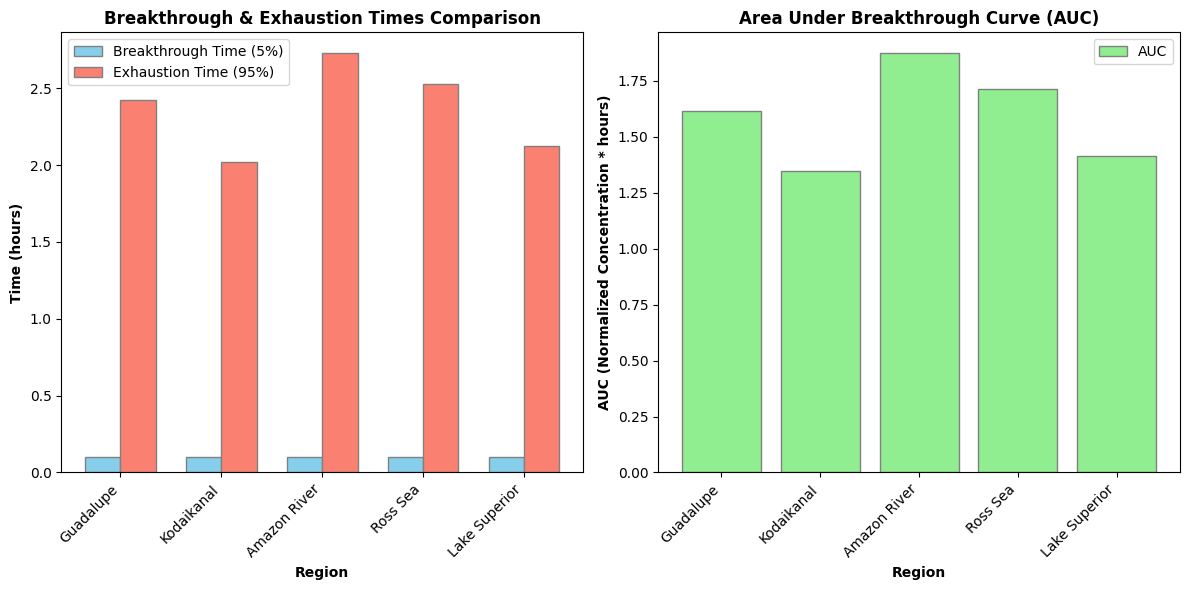

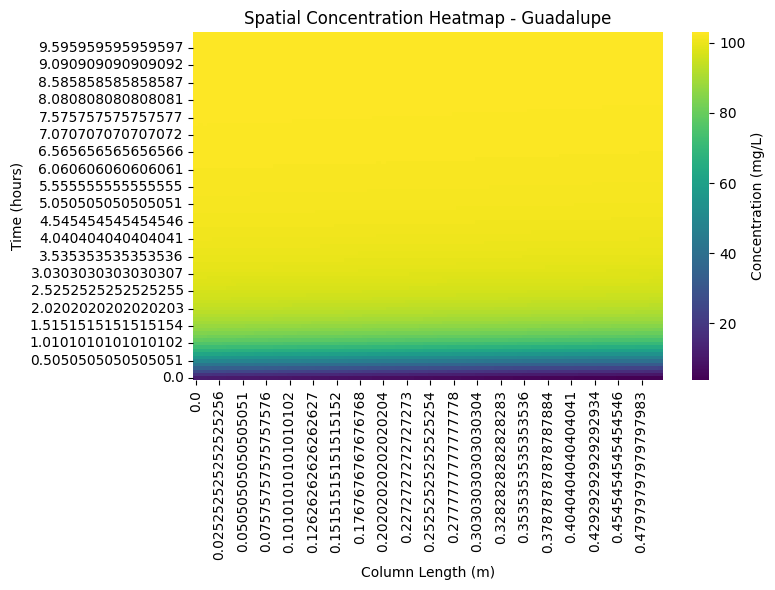

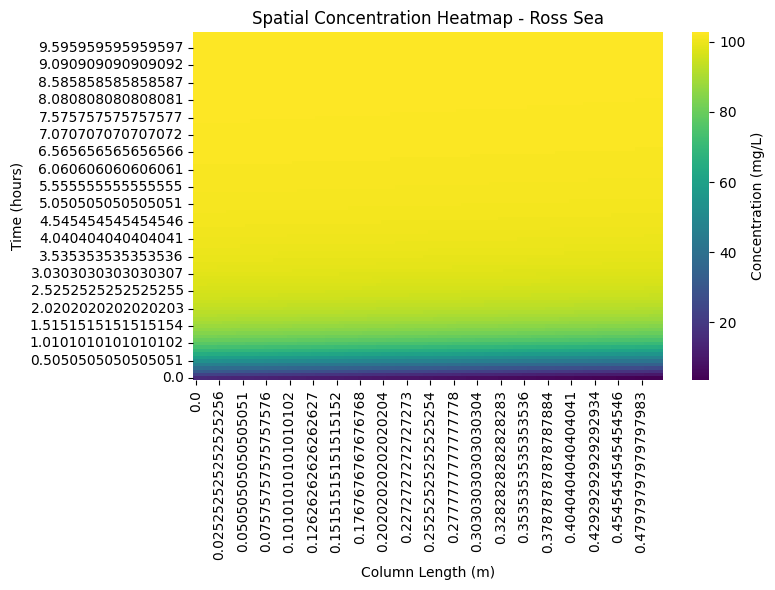

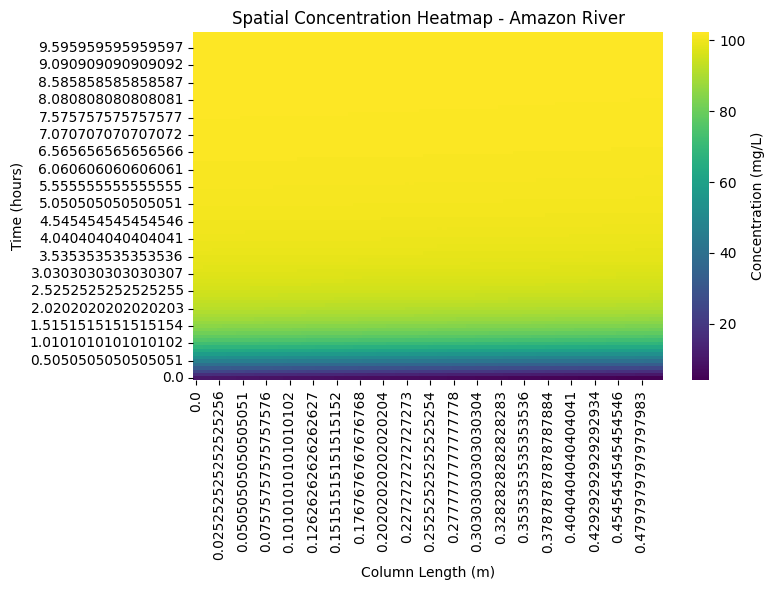

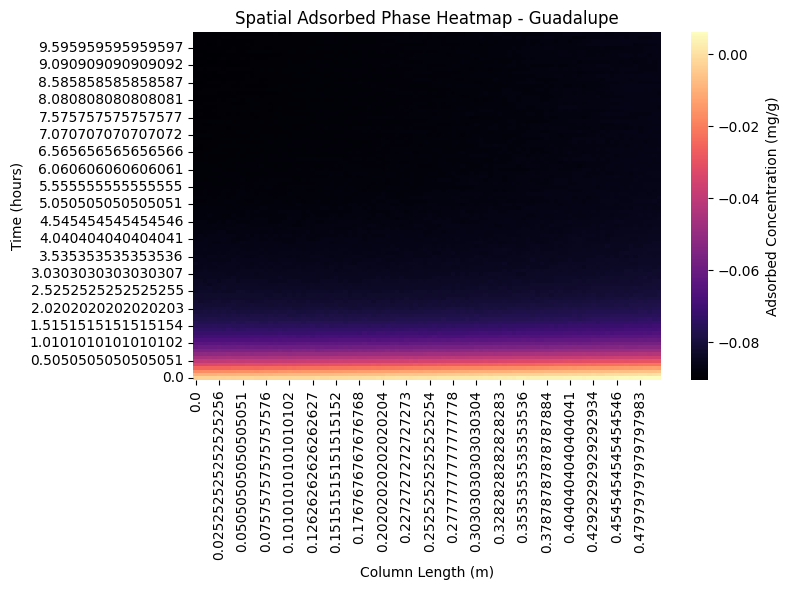

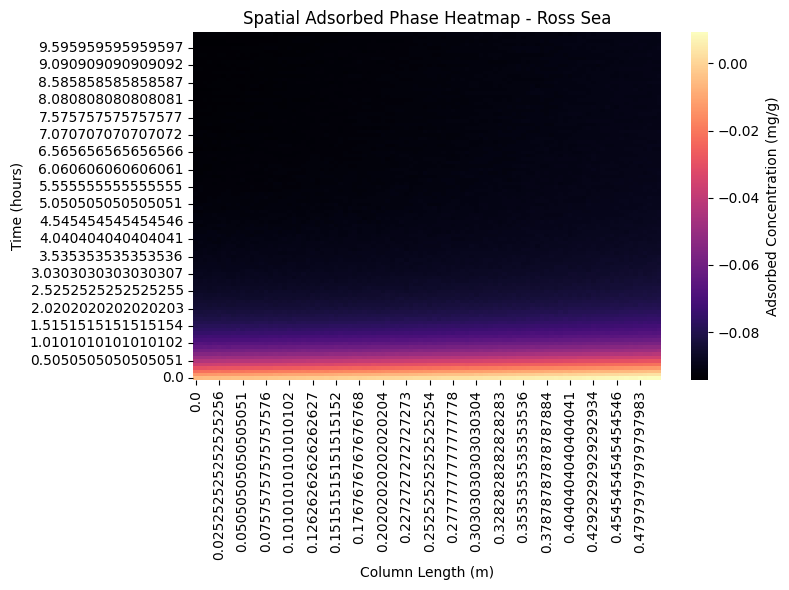

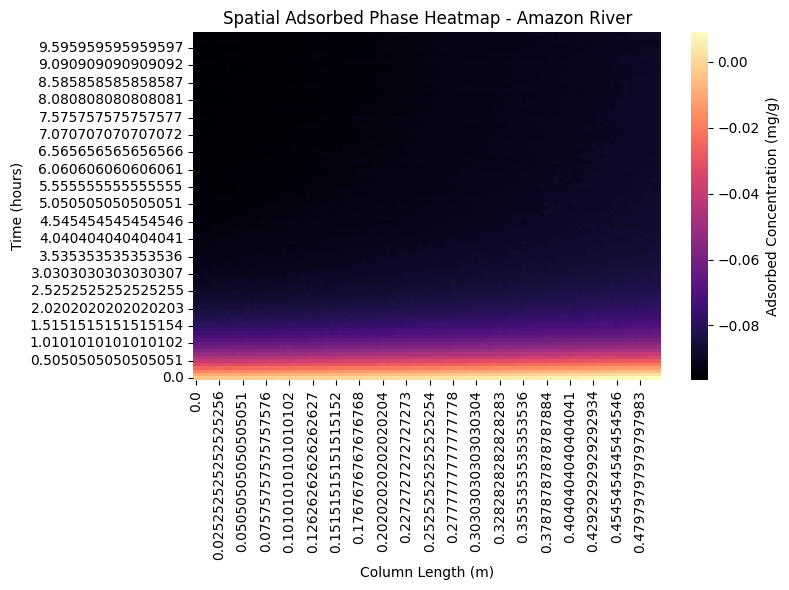

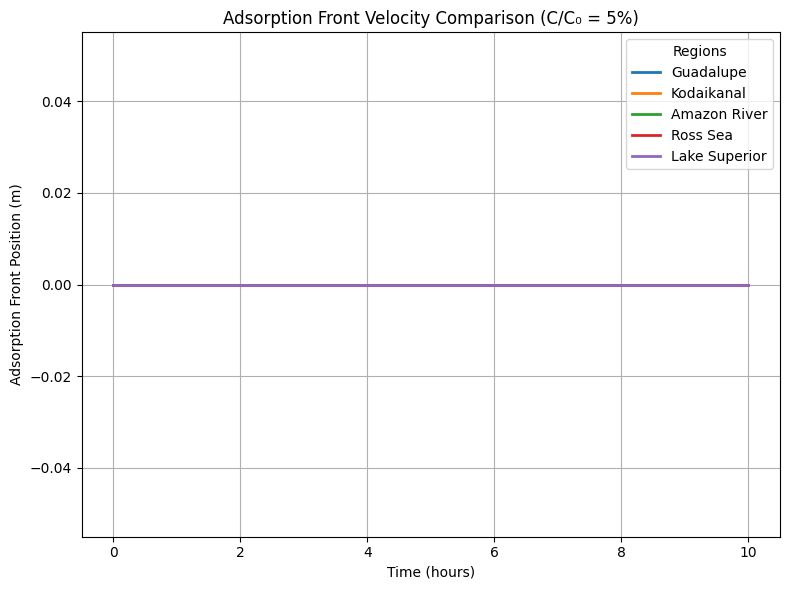


--- Visualization Phase Completed ---


In [ ]:

# --- Visualization Phase Code Block ---
def visualization_phase(breakthrough_data, spatial_data):
    """
    Generates all the plots based on the provided data.

    Args:
        breakthrough_data (dict): Dictionary containing breakthrough curve data per region.
        spatial_data (dict): Dictionary containing spatial concentration data per region.
    """
    region_names = list(region_diffusivities.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_names)))


    # --- Integrated Breakthrough Curve Plot ---
    plt.figure(figsize=(10, 6))
    for i, region_name in enumerate(region_names):
        data = breakthrough_data[region_name]
        plt.plot(data['t_array'], data['C_normalized'], label=region_name, color=colors[i])

    plt.xlabel('Time (hours)')
    plt.ylabel('C/C₀')
    plt.title('Breakthrough Curves for Different Regions')
    plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
    plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # --- Spatial Profile Figures (Separate plots per region) ---
    spatial_profiles_figures = {}
    for region_name in region_names:
        spatial_fig = plt.figure()
        spatial_profiles_figures[region_name] = spatial_fig
        ax_spatial = spatial_fig.add_subplot(1, 1, 1)
        C_pred = spatial_data[region_name]['C_spatial']
        x = spatial_data[region_name]['x']
        t = spatial_data[region_name]['t']
        num_time_points = C_pred.shape[0]
        time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
        time_labels_spatial = [f'{t[ti] / 3600:.1f} hours' for ti in time_indices]
        for idx, ti in enumerate(time_indices):
            ax_spatial.plot(x, C_pred[ti, :], label=f'Time: {time_labels_spatial[idx]}')
        ax_spatial.set_xlabel('Column Length (m)')
        ax_spatial.set_ylabel('Concentration (mg/L)')
        ax_spatial.set_title(f'Spatial Concentration Profiles - {region_name}')
        ax_spatial.legend(title='Time Points')
        ax_spatial.grid(True)
        spatial_fig.tight_layout()
        spatial_fig.show()


    # --- Contrastive Visualizations (Bar Plots) ---
    plt.figure(figsize=(12, 6))

    breakthrough_times = {}
    exhaustion_times = {}
    auc_values = {}

    for region_name, data in breakthrough_data.items():
        C_normalized = data['C_normalized']
        t_array = data['t_array']

        #Find Breakthrough Time (5%)
        breakthrough_index = np.where(C_normalized >= 0.05)[0]
        if len(breakthrough_index) > 0:
            breakthrough_times[region_name] = t_array[breakthrough_index[0]]
        else:
            breakthrough_times[region_name] = np.nan

        #Find Exhaustion Time (95%)
        exhaustion_index = np.where(C_normalized >= 0.95)[0]
        if len(exhaustion_index) > 0:
            exhaustion_times[region_name] = t_array[exhaustion_index[0]]
        else:
            exhaustion_times[region_name] = np.nan

        # Calculate AUC
        valid_indices_auc = np.where(~np.isnan(C_normalized))[0] # Avoid NaN in integration
        if not np.isnan(exhaustion_times[region_name]):
            exhaustion_time_auc = exhaustion_times[region_name]
            exhaustion_index_auc = np.where(t_array <= exhaustion_time_auc)[0][-1] if len(np.where(t_array <= exhaustion_time_auc)[0]) > 0 else -1
            if exhaustion_index_auc > 0:
                auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])
            else:
                 auc_values[region_name] = 0
        else: #If no exhaustion, calculate AUC over full simulation time.
            auc_values[region_name] = trapz(C_normalized[valid_indices_auc], t_array[valid_indices_auc]) if len(valid_indices_auc) > 1 else 0


    bar_width = 0.35
    r1 = np.arange(len(region_names))
    r2 = [x + bar_width for x in r1]

    plt.subplot(1, 2, 1)
    plt.bar(r1, [breakthrough_times.get(region, 0) for region in region_names], color='skyblue', width=bar_width, edgecolor='grey', label='Breakthrough Time (5%)')
    plt.bar(r2, [exhaustion_times.get(region, 0) for region in region_names], color='salmon', width=bar_width, edgecolor='grey', label='Exhaustion Time (95%)')
    plt.xlabel('Region', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in r1], region_names, rotation=45, ha='right')
    plt.ylabel('Time (hours)', fontweight='bold')
    plt.title('Breakthrough & Exhaustion Times Comparison', fontweight='bold')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.bar(region_names, [auc_values.get(region, 0) for region in region_names], color='lightgreen', edgecolor='grey', label='AUC')
    plt.xlabel('Region', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('AUC (Normalized Concentration * hours)', fontweight='bold')
    plt.title('Area Under Breakthrough Curve (AUC)', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- Additional High-Impact Visualizations (Heatmaps & Front Velocity) ---
    plot_concentration_heatmap(spatial_data, region_names, selected_regions=["Guadalupe", "Ross Sea", "Amazon River"])
    plot_adsorbed_phase_heatmap(spatial_data, region_names, selected_regions=["Guadalupe", "Ross Sea", "Amazon River"])
    plot_adsorption_front_velocity(breakthrough_data, region_names, front_level=0.05)


def plot_concentration_heatmap(spatial_data, region_names, selected_regions=None): # [Modified cbar_label to cbar_kws]
    if selected_regions is None:
        regions_to_plot = region_names
    else:
        regions_to_plot = selected_regions

    for region_name in regions_to_plot:
        data = spatial_data[region_name]
        C_spatial = data['C_spatial']
        x = data['x']
        t = data['t']
        df_C = pd.DataFrame(data=C_spatial, index=t/3600, columns=x)

        plt.figure(figsize=(8, 6))
        sns.heatmap(df_C, cmap="viridis", cbar_kws={'label': 'Concentration (mg/L)'}, xticklabels=5, yticklabels=5) # Changed cbar_label to cbar_kws
        plt.xlabel('Column Length (m)')
        plt.ylabel('Time (hours)')
        plt.title(f'Spatial Concentration Heatmap - {region_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def plot_adsorbed_phase_heatmap(spatial_data, region_names, selected_regions=None): #[Modified cbar_label to cbar_kws]
    if selected_regions is None:
        regions_to_plot = region_names
    else:
        regions_to_plot = selected_regions

    for region_name in regions_to_plot:
        data = spatial_data[region_name]
        q_spatial = data['q_spatial']
        x = data['x']
        t = data['t']
        df_q = pd.DataFrame(data=q_spatial, index=t/3600, columns=x)

        plt.figure(figsize=(8, 6))
        sns.heatmap(df_q, cmap="magma", cbar_kws={'label': 'Adsorbed Concentration (mg/g)'}, xticklabels=5, yticklabels=5) # Changed cbar_label to cbar_kws
        plt.xlabel('Column Length (m)')
        plt.ylabel('Time (hours)')
        plt.title(f'Spatial Adsorbed Phase Heatmap - {region_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def plot_adsorption_front_velocity(breakthrough_data, region_names, front_level=0.05): #[No changes to plotting functions]
    plt.figure(figsize=(8, 6))
    for region_name in region_names:
        data = breakthrough_data[region_name]
        C_normalized = data['C_normalized']
        t_array = data['t_array']
        x = spatial_data[region_name]['x']

        front_positions = []
        for j_time in range(len(t_array)):
            C_profile_at_t = spatial_data[region_name]['C_spatial'][j_time,:]/C0
            breakthrough_pos_indices = np.where(C_profile_at_t >= front_level)[0]
            if len(breakthrough_pos_indices) > 0:
                front_position = x[breakthrough_pos_indices[0]]
            else:
                front_position = 0

            front_positions.append(front_position)

        plt.plot(t_array, front_positions, label=region_name, linewidth=2)

    plt.xlabel('Time (hours)')
    plt.ylabel('Adsorption Front Position (m)')
    plt.title(f'Adsorption Front Velocity Comparison (C/C₀ = {front_level*100:.0f}%)')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Visualization Phase Execution (Always runs, using loaded or newly trained data) ---
if breakthrough_data_results and spatial_data_results: # Only visualize if data loading/training was successful
    visualization_phase(breakthrough_data_results, spatial_data_results)
    print("\n--- Visualization Phase Completed ---")
else:
    print("\n--- No data available for visualization. Run training_phase with retrain=True first. ---")

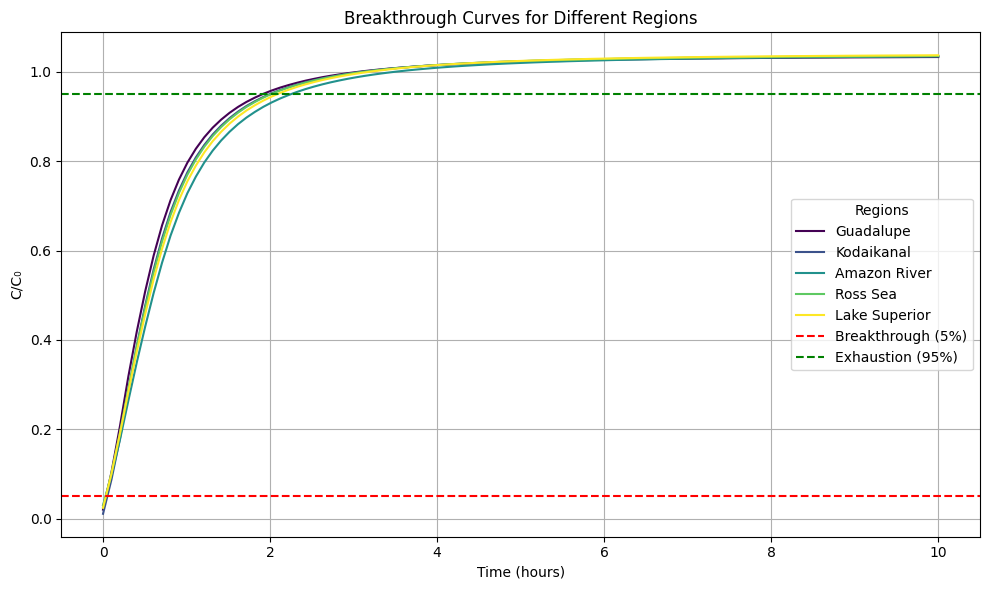

<ipython-input-19-7eeacefe8865>:85: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])


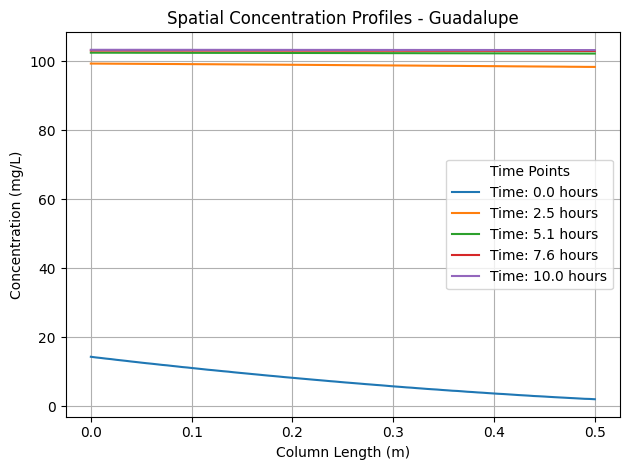

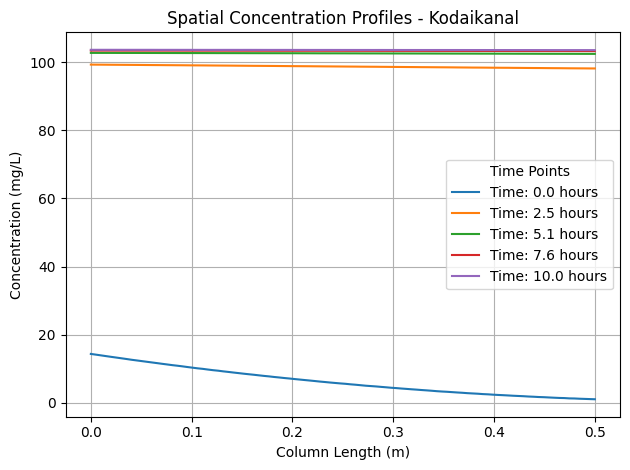

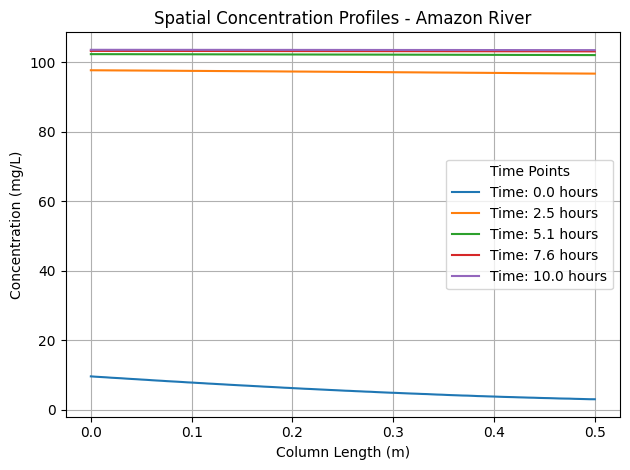

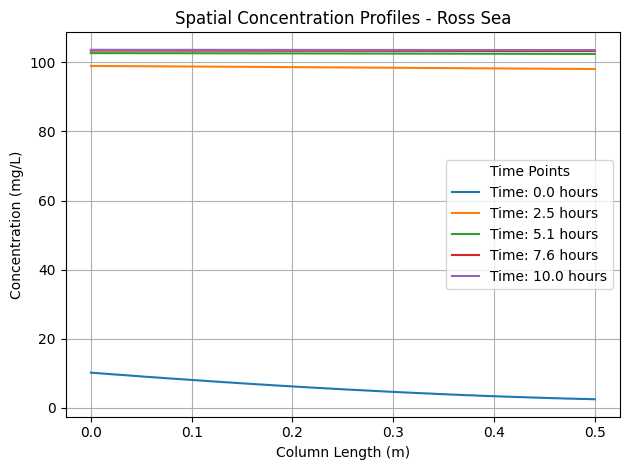

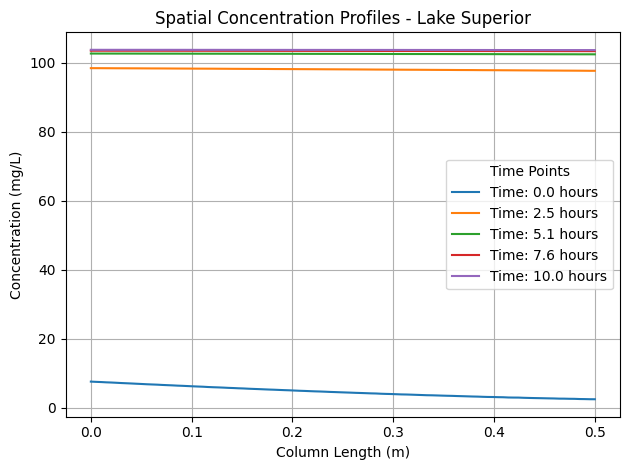

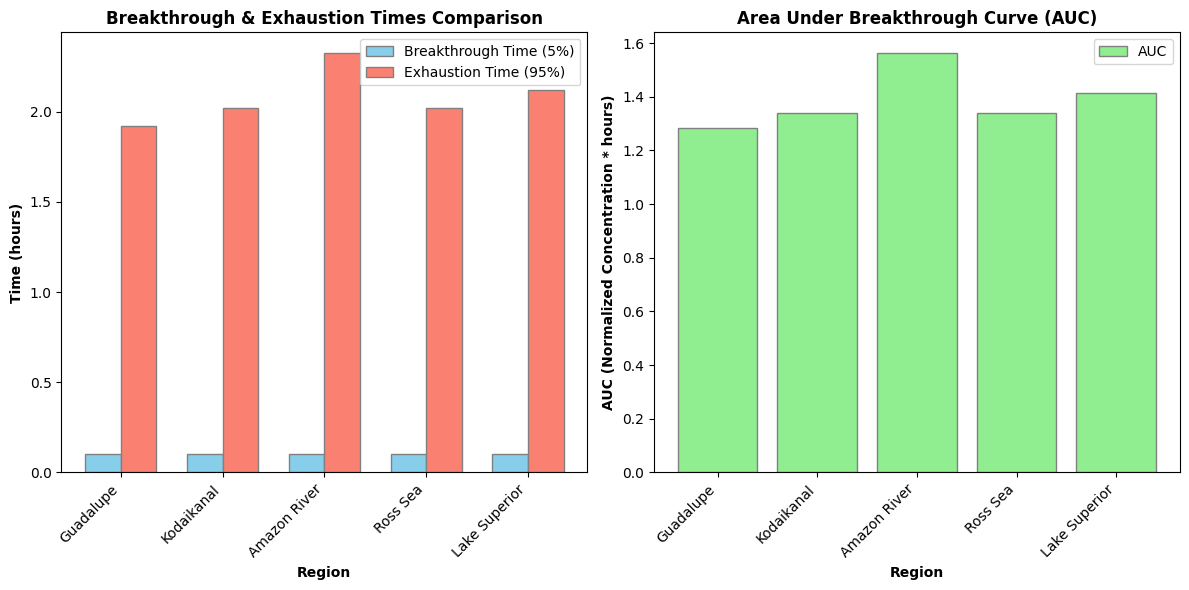

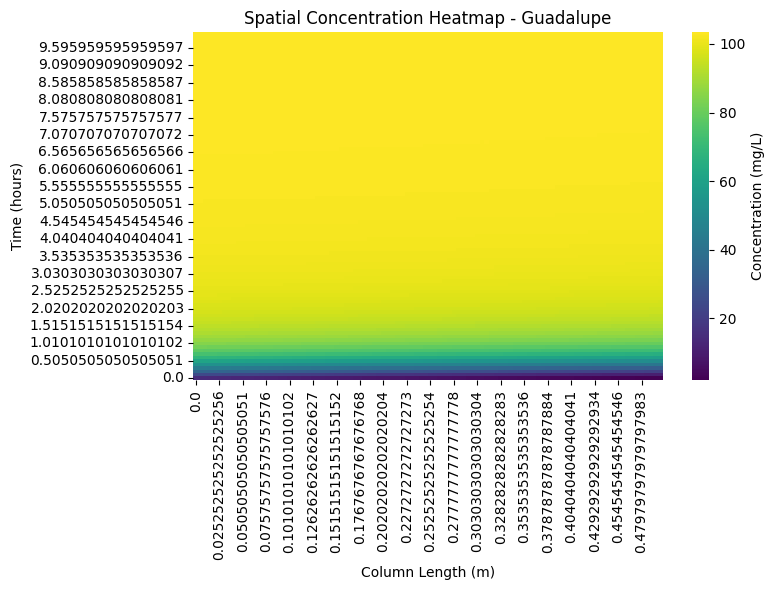

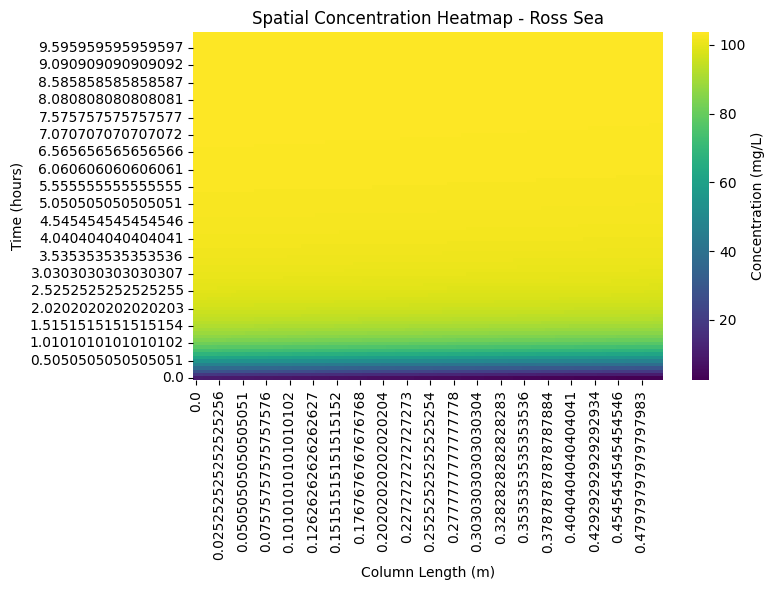

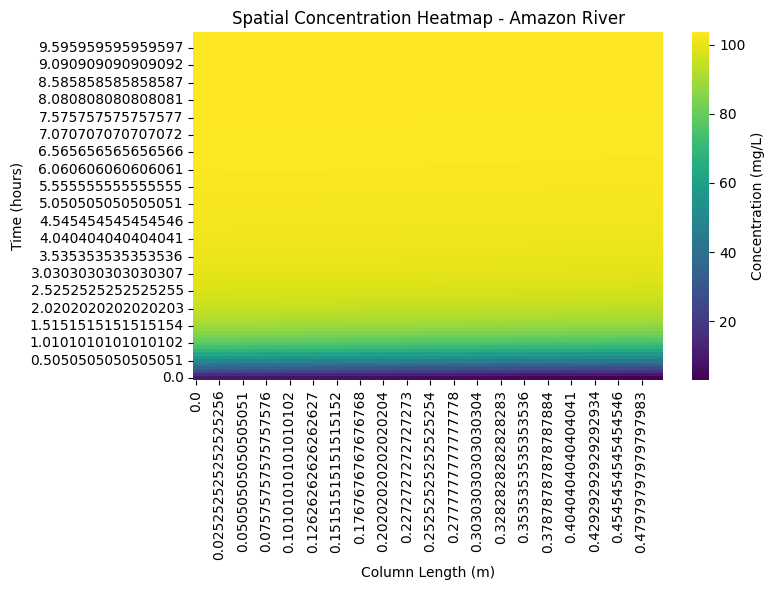

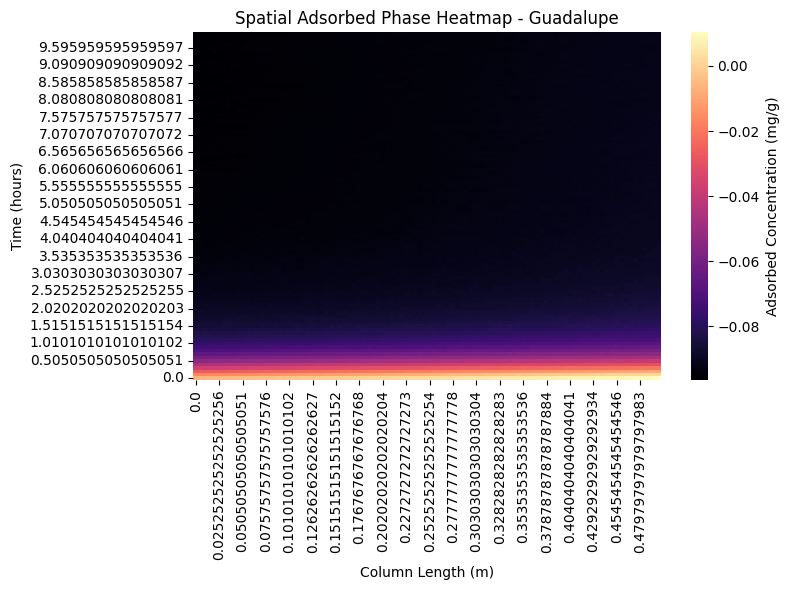

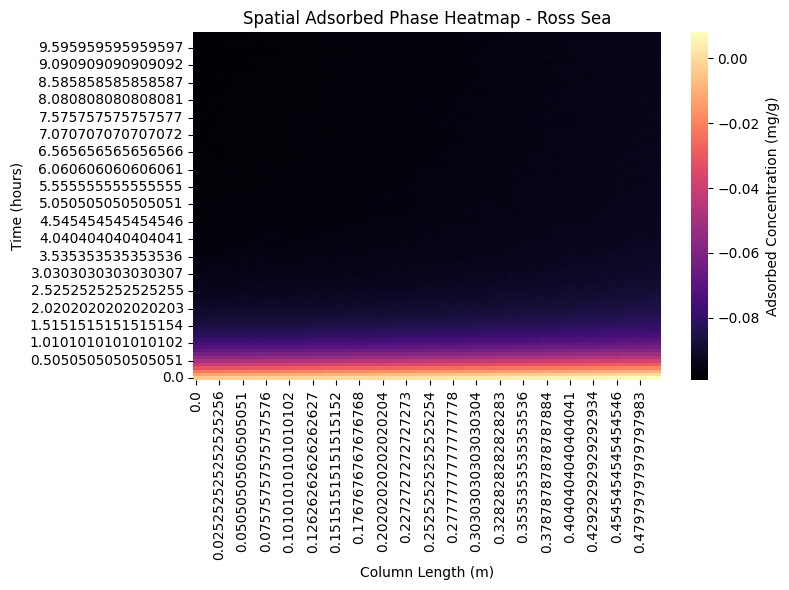

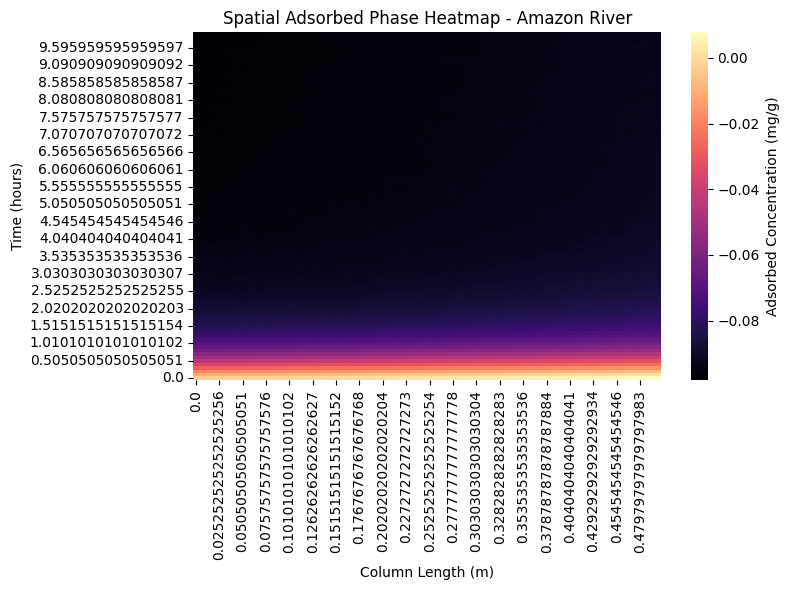

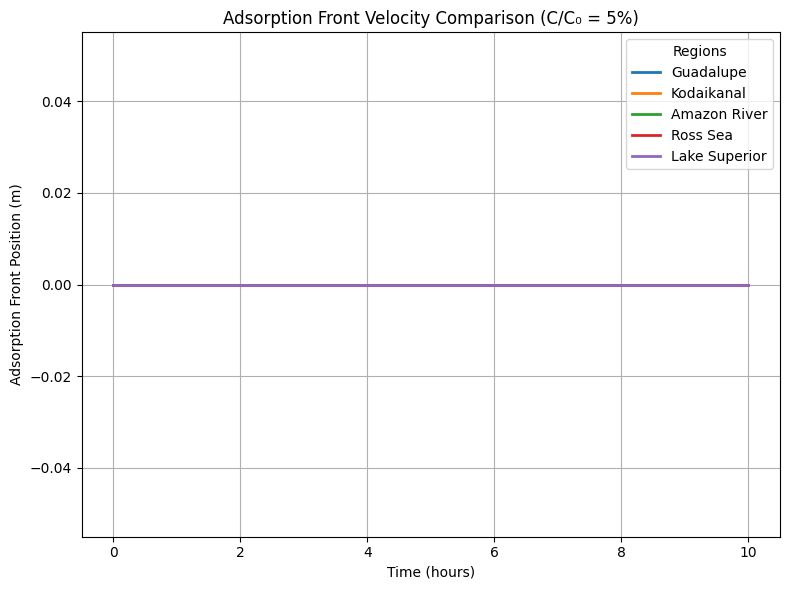


--- Previous Visualizations Completed ---

--- Generating New Difference-Highlighting Plots ---


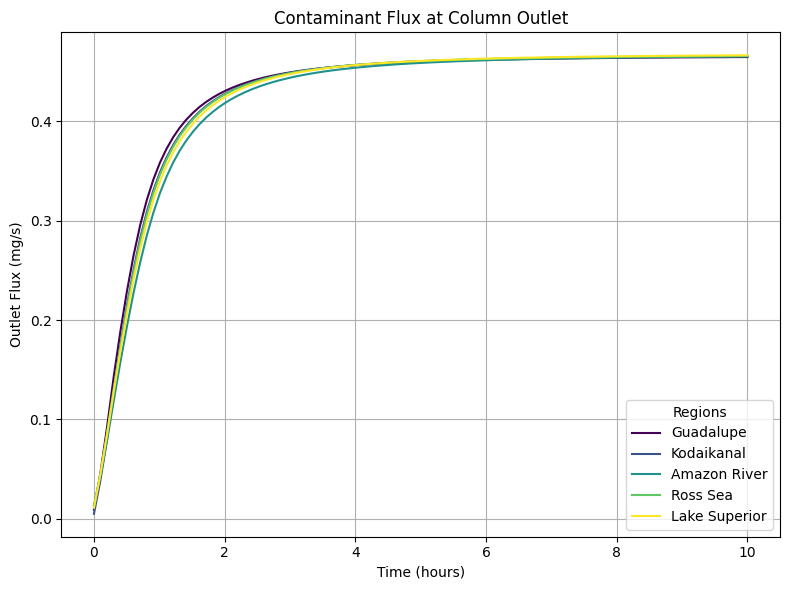

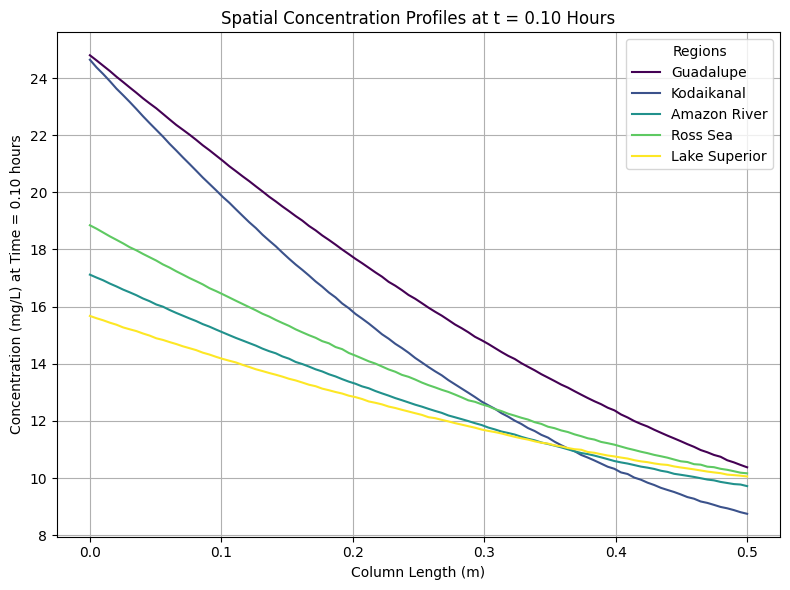


--- New Difference Visualizations Completed ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_outlet_flux(spatial_data, region_names, v=0.01, theta=0.45):
    """
    Plots the contaminant flux at the column outlet over time for each region.

    Args:
        spatial_data (dict): Dictionary containing spatial concentration data per region.
        region_names (list): List of region names.
        v (float): Pore water velocity.
        theta (float): Porosity.
    """
    plt.figure(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_names)))

    for i, region_name in enumerate(region_names):
        data = spatial_data[region_name]
        C_spatial = data['C_spatial']
        x = data['x']
        t = data['t']

        outlet_idx = np.argmin(np.abs(x - L)) # Index for outlet location
        outlet_concentration_over_time = C_spatial[:, outlet_idx]
        flux = v * theta * outlet_concentration_over_time # Flux calculation

        plt.plot(t / 3600, flux, label=region_name, color=colors[i]) # Time in hours

    plt.xlabel('Time (hours)')
    plt.ylabel('Outlet Flux (mg/s)') # Units: mass/time (assuming volume flow rate is implicitly m^3/s)
    plt.title('Contaminant Flux at Column Outlet')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_spatial_concentration_at_time(spatial_data, region_names, time_point_hours=0.1):
    """
    Plots spatial concentration profiles at a specific time point for all regions.

    Args:
        spatial_data (dict): Dictionary containing spatial concentration data per region.
        region_names (list): List of region names.
        time_point_hours (float): Time point to plot spatial profiles at (in hours).
    """
    plt.figure(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_names)))

    for i, region_name in enumerate(region_names):
        data = spatial_data[region_name]
        C_spatial = data['C_spatial']
        x = data['x']
        t = data['t']

        time_index = np.argmin(np.abs(t / 3600 - time_point_hours)) # Find index for closest time
        C_spatial_at_time = C_spatial[time_index, :]

        plt.plot(x, C_spatial_at_time, label=region_name, color=colors[i])

    plt.xlabel('Column Length (m)')
    plt.ylabel(f'Concentration (mg/L) at Time = {time_point_hours:.2f} hours')
    plt.title(f'Spatial Concentration Profiles at t = {time_point_hours:.2f} Hours')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_spatial_concentration_ratio(spatial_data, region_names, baseline_region="Guadalupe", time_point_hours=0.1):
    """
    Plots the ratio of spatial concentration profiles relative to a baseline region at a specific time.

    Args:
        spatial_data (dict): Dictionary containing spatial concentration data per region.
        region_names (list): List of region names.
        baseline_region (str): Name of the region to use as the baseline for ratio calculation.
        time_point_hours (float): Time point to plot spatial profiles at (in hours).
    """
    plt.figure(figsize=(16, 12))
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_names)))

    baseline_data = spatial_data[baseline_region]
    t_baseline = baseline_data['t']
    time_index_baseline = np.argmin(np.abs(t_baseline / 3600 - time_point_hours))
    C_spatial_baseline = baseline_data['C_spatial'][time_index_baseline, :]


    for i, region_name in enumerate(region_names):
        if region_name == baseline_region: # Skip baseline region in ratio plot
            continue

        data = spatial_data[region_name]
        C_spatial = data['C_spatial']
        x = data['x']
        t = data['t']

        time_index = np.argmin(np.abs(t / 3600 - time_point_hours))
        C_spatial_at_time = C_spatial[time_index, :]

        concentration_ratio = C_spatial_at_time / C_spatial_baseline

        plt.plot(x, concentration_ratio, label=f'{region_name} / {baseline_region}', color=colors[i])

    plt.xlabel('Column Length (m)')
    plt.ylabel(f'Concentration Ratio (C_Region / C_{baseline_region}) at Time = {time_point_hours:.2f} hours')
    plt.title(f'Spatial Concentration Ratio (Relative to {baseline_region}) at t = {time_point_hours:.2f} Hours')
    plt.legend(title='Regions Ratio')
    plt.grid(True)
    plt.axhline(y=1, color='grey', linestyle='--', linewidth=0.8) # Line at ratio = 1 for reference
    plt.tight_layout()
    plt.show()



# --- Visualization Phase Execution (Always runs, using loaded or newly trained data) ---
if breakthrough_data_results and spatial_data_results: # Only visualize if data loading/training was successful
    visualization_phase(breakthrough_data_results, spatial_data_results) # Keep existing visualizations
    print("\n--- Previous Visualizations Completed ---")

    # --- New Plots to Show Differences ---
    print("\n--- Generating New Difference-Highlighting Plots ---")

    plot_outlet_flux(spatial_data_results, region_names) # Plot Outlet Flux

    time_for_spatial_profiles = 0.1 # Choose a time in the breakthrough phase (e.g., 0.1 hours)
    plot_spatial_concentration_at_time(spatial_data_results, region_names, time_point_hours=time_for_spatial_profiles) # Spatial profiles at a specific time

    #plot_spatial_concentration_ratio(spatial_data_results, region_names, baseline_region="Guadalupe", time_point_hours=time_for_spatial_profiles) # Ratio plot

    print("\n--- New Difference Visualizations Completed ---")


else:
    print("\n--- No data available for visualization. Run training_phase with retrain=True first. ---")

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import seaborn as sns
import pandas as pd
import pickle # For saving and loading data

# --- Parameters (Keep these at the top for easy modification) ---
# Adsorption Parameters
v = 0.01
rho_b = 450
theta = 0.45
q_max = 0.6
K_L = 0.15
L = 0.5
T = 36000
C0 = 100

# Kinetic Parameters
k_f = 2e-4
k_r = k_f / K_L

# Diffusivity Values
region_diffusivities = {
    "Guadalupe": 8.41e-10,
    "Kodaikanal": 7.45e-10,
    "Amazon River": 9.91e-10,
    "Ross Sea": 1.23e-10,
    "Lake Superior": 4.53e-10,
}

T_scaled_max = 1.0
region_names = list(region_diffusivities.keys())


# --- Training Phase Code Block ---
def training_phase(retrain=False, save_data=True, data_filename="pinn_data.pkl"):
    """
    Executes the PINN training for each region and saves the results.

    Args:
        retrain (bool): If True, retrains the model for all regions. If False, loads saved data if available.
        save_data (bool): If True, saves the generated data to a pickle file.
        data_filename (str): Filename for saving/loading data.

    Returns:
        tuple: breakthrough_data, spatial_data dictionaries.
               Returns None, None if loading fails and retrain is False.
    """

    if not retrain:
        try:
            with open(data_filename, 'rb') as f:
                loaded_data = pickle.load(f)
                print(f"--- Loaded data from {data_filename} ---")
                return loaded_data['breakthrough_data'], loaded_data['spatial_data']
        except FileNotFoundError:
            print("--- No saved data found. Proceeding with training. ---")
        except Exception as e:
            print(f"--- Error loading data: {e}. Proceeding with training. ---")


    breakthrough_data = {}
    spatial_data = {}

    for region_name in region_names:
        D = region_diffusivities[region_name]
        print(f"\n--- Training for Region: {region_name} (D = {D:.2e}) ---")

        # Domain, PDE, BCs, ICs, Data - [No changes here from previous code]
        geom = dde.geometry.Interval(0, L)
        timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
        geomtime = dde.geometry.GeometryXTime(geom, timedomain)

        def pde(x, y):
            C = y[:, 0:1]
            q = y[:, 1:2]
            dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
            dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
            d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
            dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
            adsorption_rate = k_f * C * (q_max - q) - k_r * q
            pde_C = dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt
            pde_q = dq_dt - adsorption_rate
            return [pde_C, pde_q]

        def boundary_inlet(x, on_boundary):
            return on_boundary and np.isclose(x[0], 0)
        def boundary_outlet(x, on_boundary):
            return on_boundary and np.isclose(x[0], L)
        ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
        ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
        bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
        bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

        data = dde.data.TimePDE(
            geomtime,
            pde,
            [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
            num_domain=2000,
            num_boundary=200,
            num_initial=100,
            num_test=500
        )

        net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
        model = dde.Model(data, net)

        model.compile("adam", lr=1e-3)
        model.train(iterations=5000, display_every=1000)
        model.compile("L-BFGS")
        model.train()

        # Prediction - [No changes here from previous code]
        x = np.linspace(0, L, 100)
        t_scaled = np.linspace(0, T_scaled_max, 100)
        t = t_scaled * T
        X, T_scaled_grid = np.meshgrid(x, t_scaled)
        grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
        y_pred = model.predict(grid)
        C_pred = y_pred[:, 0:1].reshape(X.shape)
        q_pred = y_pred[:, 1:2].reshape(X.shape)

        # Breakthrough curve calculation - [No changes here from previous code]
        outlet_idx = np.argmin(np.abs(x - L))
        breakthrough_curve = C_pred[:, outlet_idx]
        C_normalized = breakthrough_curve / C0
        t_array = t / 3600

        breakthrough_data[region_name] = {
            'C_normalized': C_normalized,
            't_array': t_array
        }
        spatial_data[region_name] = {
            'C_spatial': C_pred,
            'q_spatial': q_pred,
            'x': x,
            't': t
        }

    if save_data:
        data_to_save = {'breakthrough_data': breakthrough_data, 'spatial_data': spatial_data}
        with open(data_filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"--- Data saved to {data_filename} ---")

    return breakthrough_data, spatial_data


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import seaborn as sns
import pandas as pd
import pickle # For saving and loading data

# --- Parameters (Keep these at the top for easy modification) ---
# Adsorption Parameters
v = 0.01
rho_b = 450
theta = 0.45
q_max = 0.6
K_L = 0.15
L = 0.5
T = 3600
C0 = 100

# Kinetic Parameters
k_f = 2e-4
k_r = k_f / K_L

# Diffusivity Values
region_diffusivities = {
    "Guadalupe": 8.41e-10,
    "Kodaikanal": 7.45e-10,
    "Amazon River": 9.91e-10,
    "Weddell Sea": 1.23e-10,
    "Lake Superior": 4.53e-10,
}

T_scaled_max = 1.0
region_names = list(region_diffusivities.keys())
# Define consistent colors for regions - outside functions
colors = plt.cm.viridis(np.linspace(0, 1, len(region_names)))
region_color_map = dict(zip(region_names, colors)) # Map region name to color


# --- Training Phase Code Block ---
def training_phase(retrain=False, save_data=True, data_filename="pinn_data.pkl"):
    """
    Executes the PINN training for each region and saves the results.

    Args:
        retrain (bool): If True, retrains the model for all regions. If False, loads saved data if available.
        save_data (bool): If True, saves the generated data to a pickle file.
        data_filename (str): Filename for saving/loading data.

    Returns:
        tuple: breakthrough_data, spatial_data dictionaries.
               Returns None, None if loading fails and retrain is False.
    """

    if not retrain:
        try:
            with open(data_filename, 'rb') as f:
                loaded_data = pickle.load(f)
                print(f"--- Loaded data from {data_filename} ---")
                return loaded_data['breakthrough_data'], loaded_data['spatial_data']
        except FileNotFoundError:
            print("--- No saved data found. Proceeding with training. ---")
        except Exception as e:
            print(f"--- Error loading data: {e}. Proceeding with training. ---")


    breakthrough_data = {}
    spatial_data = {}

    for region_name in region_names:
        D = region_diffusivities[region_name]
        print(f"\n--- Training for Region: {region_name} (D = {D:.2e}) ---")

        # Domain, PDE, BCs, ICs, Data - [No changes here from previous code]
        geom = dde.geometry.Interval(0, L)
        timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
        geomtime = dde.geometry.GeometryXTime(geom, timedomain)

        def pde(x, y):
            C = y[:, 0:1]
            q = y[:, 1:2]
            dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
            dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
            d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
            dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
            adsorption_rate = k_f * C * (q_max - q) - k_r * q
            pde_C = dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt
            pde_q = dq_dt - adsorption_rate
            return [pde_C, pde_q]

        def boundary_inlet(x, on_boundary):
            return on_boundary and np.isclose(x[0], 0)
        def boundary_outlet(x, on_boundary):
            return on_boundary and np.isclose(x[0], L)
        ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
        ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
        bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
        bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

        data = dde.data.TimePDE(
            geomtime,
            pde,
            [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
            num_domain=2000,
            num_boundary=200,
            num_initial=100,
            num_test=500
        )

        net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
        model = dde.Model(data, net)

        model.compile("adam", lr=1e-3)
        model.train(iterations=5000, display_every=1000)
        model.compile("L-BFGS")
        model.train()

        # Prediction - [No changes here from previous code]
        x = np.linspace(0, L, 100)
        t_scaled = np.linspace(0, T_scaled_max, 100)
        t = t_scaled * T
        X, T_scaled_grid = np.meshgrid(x, t_scaled)
        grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
        y_pred = model.predict(grid)
        C_pred = y_pred[:, 0:1].reshape(X.shape)
        q_pred = y_pred[:, 1:2].reshape(X.shape)

        # Breakthrough curve calculation - [No changes here from previous code]
        outlet_idx = np.argmin(np.abs(x - L))
        breakthrough_curve = C_pred[:, outlet_idx]
        C_normalized = breakthrough_curve / C0
        t_array = t / 3600

        breakthrough_data[region_name] = {
            'C_normalized': C_normalized,
            't_array': t_array
        }
        spatial_data[region_name] = {
            'C_spatial': C_pred,
            'q_spatial': q_pred,
            'x': x,
            't': t
        }

    if save_data:
        data_to_save = {'breakthrough_data': breakthrough_data, 'spatial_data': spatial_data}
        with open(data_filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"--- Data saved to {data_filename} ---")

    return breakthrough_data, spatial_data



No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:

# --- Visualization Phase Code Block ---
def visualization_phase(breakthrough_data, spatial_data):
    """
    Generates all the plots based on the provided data.

    Args:
        breakthrough_data (dict): Dictionary containing breakthrough curve data per region.
        spatial_data (dict): Dictionary containing spatial concentration data per region.
    """
    region_names = list(region_diffusivities.keys())


    # --- Integrated Breakthrough Curve Plot ---
    plt.figure(figsize=(10, 6))
    for i, region_name in enumerate(region_names):
        data = breakthrough_data[region_name]
        plt.plot(data['t_array'], data['C_normalized'], label=region_name, color=region_color_map[region_name])

    plt.xlabel('Time (hours)')
    plt.ylabel('C/C₀')
    plt.title('Breakthrough Curves for Different Regions')
    plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
    plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # --- Contrastive Visualizations (Bar Plots) ---
    plt.figure(figsize=(12, 6))

    breakthrough_times = {}
    exhaustion_times = {}
    auc_values = {}

    for region_name, data in breakthrough_data.items():
        C_normalized = data['C_normalized']
        t_array = data['t_array']

        #Find Breakthrough Time (5%)
        breakthrough_index = np.where(C_normalized >= 0.05)[0]
        if len(breakthrough_index) > 0:
            breakthrough_times[region_name] = t_array[breakthrough_index[0]]
        else:
            breakthrough_times[region_name] = np.nan

        #Find Exhaustion Time (95%)
        exhaustion_index = np.where(C_normalized >= 0.95)[0]
        if len(exhaustion_index) > 0:
            exhaustion_times[region_name] = t_array[exhaustion_index[0]]
        else:
            exhaustion_times[region_name] = np.nan

        # Calculate AUC
        valid_indices_auc = np.where(~np.isnan(C_normalized))[0] # Avoid NaN in integration
        if not np.isnan(exhaustion_times[region_name]):
            exhaustion_time_auc = exhaustion_times[region_name]
            exhaustion_index_auc = np.where(t_array <= exhaustion_time_auc)[0][-1] if len(np.where(t_array <= exhaustion_time_auc)[0]) > 0 else -1
            if exhaustion_index_auc > 0:
                auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])
            else:
                 auc_values[region_name] = 0
        else: #If no exhaustion, calculate AUC over full simulation time.
            auc_values[region_name] = trapz(C_normalized[valid_indices_auc], t_array[valid_indices_auc]) if len(valid_indices_auc) > 1 else 0


    bar_width = 0.35
    r1 = np.arange(len(region_names))
    r2 = [x + bar_width for x in r1]

    plt.subplot(1, 2, 1)
    plt.bar(r1, [breakthrough_times.get(region, 0) for region in region_names], color='skyblue', width=bar_width, edgecolor='grey', label='Breakthrough Time (5%)')
    plt.bar(r2, [exhaustion_times.get(region, 0) for region in region_names], color='salmon', width=bar_width, edgecolor='grey', label='Exhaustion Time (95%)')
    plt.xlabel('Region', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in r1], region_names, rotation=45, ha='right')
    plt.ylabel('Time (hours)', fontweight='bold')
    plt.title('Breakthrough & Exhaustion Times Comparison', fontweight='bold')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.bar(region_names, [auc_values.get(region, 0) for region in region_names], color='lightgreen', edgecolor='grey', label='AUC')
    plt.xlabel('Region', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('AUC (Normalized Concentration * hours)', fontweight='bold')
    plt.title('Area Under Breakthrough Curve (AUC)', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- Additional High-Impact Visualizations (Heatmaps & Front Velocity) ---
    #plot_concentration_heatmap(spatial_data, region_names, selected_regions=["Guadalupe", "Ross Sea", "Amazon River"])
    #plot_adsorbed_phase_heatmap(spatial_data, region_names, selected_regions=["Guadalupe", "Ross Sea", "Amazon River"])
    #plot_adsorption_front_velocity(breakthrough_data, region_names, front_level=0.05)


def plot_concentration_heatmap(spatial_data, region_names, selected_regions=None): # [Modified cbar_label to cbar_kws]
    if selected_regions is None:
        regions_to_plot = region_names
    else:
        regions_to_plot = selected_regions

    for region_name in regions_to_plot:
        data = spatial_data[region_name]
        C_spatial = data['C_spatial']
        x = data['x']
        t = data['t']
        df_C = pd.DataFrame(data=C_spatial, index=t/3600, columns=x)

        plt.figure(figsize=(8, 6))
        sns.heatmap(df_C, cmap="viridis", cbar_kws={'label': 'Concentration (mg/L)'}, xticklabels=5, yticklabels=5) # Changed cbar_label to cbar_kws
        plt.xlabel('Column Length (m)')
        plt.ylabel('Time (hours)')
        plt.title(f'Spatial Concentration Heatmap - {region_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def plot_adsorbed_phase_heatmap(spatial_data, region_names, selected_regions=None): #[Modified cbar_label to cbar_kws]
    if selected_regions is None:
        regions_to_plot = region_names
    else:
        regions_to_plot = selected_regions

    for region_name in regions_to_plot:
        data = spatial_data[region_name]
        q_spatial = data['q_spatial']
        x = data['x']
        t = data['t']
        df_q = pd.DataFrame(data=q_spatial, index=t/3600, columns=x)

        plt.figure(figsize=(8, 6))
        sns.heatmap(df_q, cmap="magma", cbar_kws={'label': 'Adsorbed Concentration (mg/g)'}, xticklabels=5, yticklabels=5) # Changed cbar_label to cbar_kws
        plt.xlabel('Column Length (m)')
        plt.ylabel('Time (hours)')
        plt.title(f'Spatial Adsorbed Phase Heatmap - {region_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def plot_adsorption_front_velocity(breakthrough_data, region_names, front_level=0.05): #[No changes to plotting functions]
    plt.figure(figsize=(8, 6))
    for region_name in region_names:
        data = breakthrough_data[region_name]
        C_normalized = data['C_normalized']
        t_array = data['t_array']
        x = spatial_data[region_name]['x']

        front_positions = []
        for j_time in range(len(t_array)):
            C_profile_at_t = spatial_data[region_name]['C_spatial'][j_time,:]/C0
            breakthrough_pos_indices = np.where(C_profile_at_t >= front_level)[0]
            if len(breakthrough_pos_indices) > 0:
                front_position = x[breakthrough_pos_indices[0]]
            else:
                front_position = 0

            front_positions.append(front_position)

        plt.plot(t_array, front_positions, label=region_name, linewidth=2, color=region_color_map[region_name]) # consistent colors

    plt.xlabel('Time (hours)')
    plt.ylabel('Adsorption Front Position (m)')
    plt.title(f'Adsorption Front Velocity Comparison (C/C₀ = {front_level*100:.0f}%)')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_faceted_spatial_concentration_at_times(spatial_data, region_names, time_points_hours):
    """
    Generates faceted plots of spatial concentration profiles at multiple time points.
    """
    num_time_points = len(time_points_hours)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjust figure size, and create axes array

    for plot_index, time_point_hours in enumerate(time_points_hours):
        ax = axes.flatten()[plot_index] # Access subplot axes using flattened index

        for i, region_name in enumerate(region_names):
            data = spatial_data[region_name]
            C_spatial = data['C_spatial']
            x = data['x']
            t = data['t']

            time_index = np.argmin(np.abs(t / 3600 - time_point_hours))
            C_spatial_at_time = C_spatial[time_index, :]

            ax.plot(x, C_spatial_at_time, label=region_name, color=region_color_map[region_name]) # Consistent colors

        ax.set_title(f't = {time_point_hours:.1f} hours')
        ax.set_xlabel('Column Length (m)')
        ax.grid(True)
        if plot_index % 3 == 0: # Label y-axis for the first column only
            ax.set_ylabel('Concentration (mg/L)')


    # Add a single legend to the entire figure outside the subplots
    handles, labels = axes.flatten()[0].get_legend_handles_labels() # Use the first subplot's handles
    fig.legend(handles, labels, loc='upper center', ncol=len(region_names), title='Regions')

    fig.suptitle('Spatial Concentration Profiles at Different Times', fontsize=14, y=0.95) # Adjust suptitle Y position
    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust tight_layout rect to make space for suptitle and legend
    plt.show()



--- No saved data found. Proceeding with training. ---

--- Training for Region: Guadalupe (D = 8.41e-10) ---
Compiling model...
Building feed-forward neural network...
'build' took 0.076014 s

'compile' took 0.991207 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.54e+04, 4.55e-02, 9.99e+03, 1.03e-02, 8.50e-04, 4.45e-03]    [4.49e+04, 4.50e-02, 9.99e+03, 1.03e-02, 8.49e-04, 4.45e-03]    []  
1000      [8.84e+01, 1.41e-03, 3.00e+03, 9.24e+01, 1.06e+03, 1.69e-01]    [6.53e+01, 1.22e-03, 3.00e+03, 9.24e+01, 1.06e+03, 1.68e-01]    []  
2000      [1.29e+01, 3.51e-02, 6.83e+02, 2.23e+01, 1.05e+02, 1.45e-03]    [1.24e+01, 2.34e-02, 6.83e+02, 2.23e+01, 1.05e+02, 1.45e-03]    []  
3000      [1.50e+02, 6.09e-02, 4.41e+02, 1.58e+01, 6.34e+01, 1.12e-04]    [6.51e+01, 3.76e-02, 4.41e+02, 1.58e+01, 6.34e+01, 1.13e-04]    []  
4000      [1.44e+03, 6.28e-02, 3.49e+0

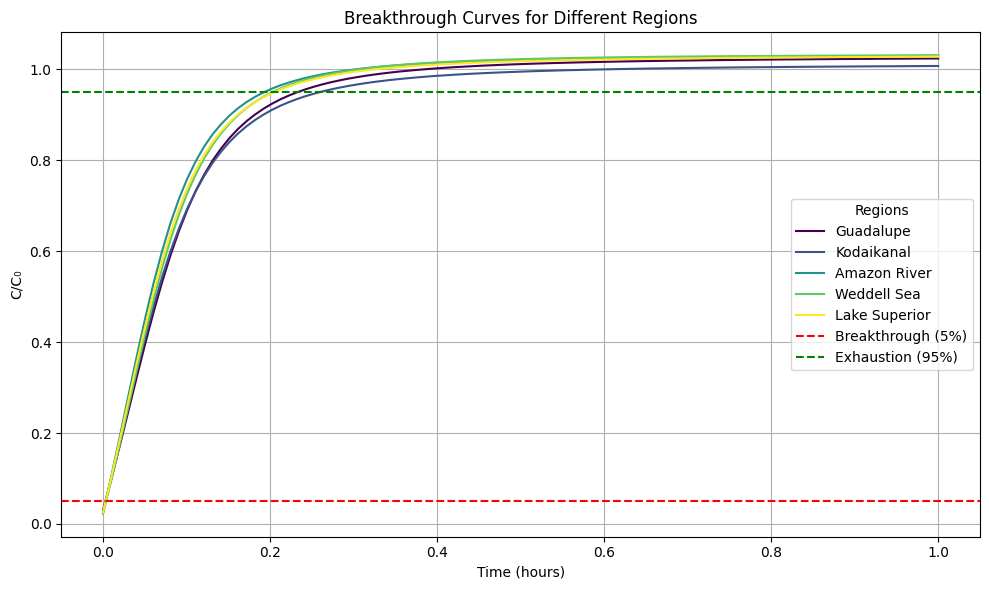

<ipython-input-3-d8df2aa4c387>:61: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])


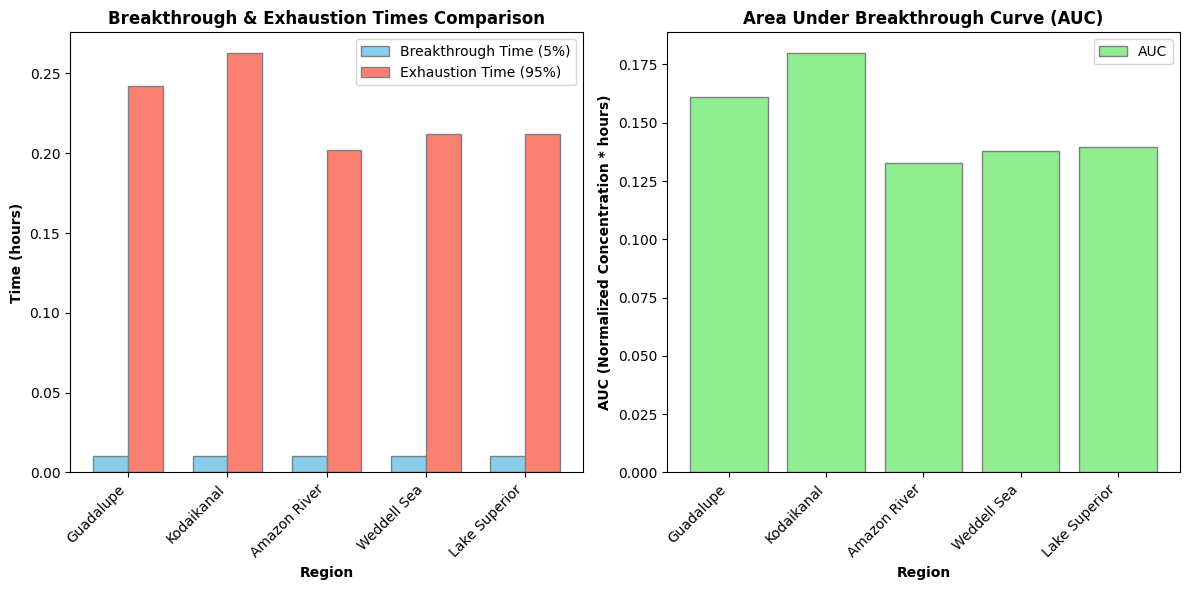


--- Previous Visualizations Completed ---

--- Generating New Difference-Highlighting Plots ---


NameError: name 'plot_outlet_flux' is not defined

In [ ]:

# --- Run Training Phase (Set retrain=True to force retraining, otherwise it loads saved data) ---
breakthrough_data_results, spatial_data_results = training_phase(retrain=False) # Set retrain=True to re-run training


# --- Visualization Phase Execution (Always runs, using loaded or newly trained data) ---
if breakthrough_data_results and spatial_data_results: # Only visualize if data loading/training was successful
    visualization_phase(breakthrough_data_results, spatial_data_results) # Keep existing visualizations
    print("\n--- Previous Visualizations Completed ---")

    # --- New Plots to Show Differences ---
    print("\n--- Generating New Difference-Highlighting Plots ---")

    plot_outlet_flux(spatial_data_results, region_names) # Plot Outlet Flux

    time_for_spatial_profiles = 0.1 # Choose a time in the breakthrough phase (e.g., 0.1 hours)
    plot_spatial_concentration_at_time(spatial_data_results, region_names, time_point_hours=time_for_spatial_profiles) # Spatial profiles at a specific time

    #plot_spatial_concentration_ratio(spatial_data_results, region_names, baseline_region="Guadalupe", time_point_hours=time_for_spatial_profiles) # Ratio plot

    print("\n--- New Difference Visualizations Completed ---")

    # --- Faceted Spatial Concentration Plot ---
    time_points_to_plot = [0.1, 0.5, 2, 10] # Time points in hours
    plot_faceted_spatial_concentration_at_times(spatial_data_results, region_names, time_points_hours=time_points_to_plot)


else:
    print("\n--- No data available for visualization. Run training_phase with retrain=True first. ---")